# Read Data

In [1]:
import pandas as pd
# Read the CSVs
footbridge = pd.read_csv('Creek Data/footbridge.csv')

grinnel=pd.read_csv('Creek Data/grinnel.csv')

lbnl_2021_2023=pd.read_csv('lbnl data/LBNL1 Weather Data 2021-2023.csv')

 'BaroPres','DeltaTemp_Avg', 'Dew_Pt_Avg','PanelTmpF_Avg', 'Precip_Tot 'RelHum_Avg''SolRad_Avg'    'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',  'VertWind_Avg', 'VertWind_Max', 'WindGust_Max', 'WndDir', 'WndDir_res',
       'WndSpd', 'WndSpd_dup', 'WndSpd_res''Temp2m_Avg'

# add rain data from open lbnl

In [2]:
import pandas as pd
import numpy as np
# The 'requests' library is no longer needed

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    """
    Cleans, standardizes, and consolidates messy sensor column names in a DataFrame.
    (This function remains unchanged)
    """
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    df.rename(columns=rename_map, inplace=True)
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        if df.columns.tolist().count(name) > 1:
            dup_cols_df = df.loc[:, df.columns == name]
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            df.drop(columns=[name], inplace=True)
            df[name] = consolidated_series

## NEW HELPER FUNCTION ##
def prepare_lbnl_weather_data(lbnl_df):
    """
    Selects required columns from the LBNL weather data, renames the timestamp,
    and prepares it for merging.
    """
    # Define the columns you want to keep from the LBNL dataset
    columns_to_keep = [
        'Timestamp (UTC-8)', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg',
        'Precip_Tot', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',
        'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max',
        'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Avg'
    ]

    # Filter for the columns we need
    weather_df = lbnl_df[columns_to_keep].copy()

    # Rename columns for consistency and merging
    weather_df.rename(columns={
        'Timestamp (UTC-8)': 'datetime',
        'Precip_Tot': 'rain_mm'  # Renaming for compatibility with plotting functions
    }, inplace=True)

    # Ensure the datetime column is the correct data type
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

    # Sort by datetime, which is required for merge_asof
    weather_df.sort_values('datetime', inplace=True)

    return weather_df

# ===================================================================
#  2. MAIN PROCESSING FUNCTION (MODIFIED)
# ===================================================================

## MODIFIED MAIN FUNCTION ##
def create_final_dataset(file_path_map, lbnl_weather_df):
    """
    Loads, cleans, and combines sensor data, then merges it with the
    provided LBNL weather DataFrame.
    """
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        df = pd.read_csv(path)
        clean_column_names(df)
        df['location'] = name
        all_sensors_list.append(df)

    # --- Combine and consolidate the cleaned sensor data ---
    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)

    # --- Prepare the local LBNL weather data ---
    print("Preparing LBNL weather data... ☀️")
    weather_df = prepare_lbnl_weather_data(lbnl_weather_df)

    # --- Merge sensor data with the nearest LBNL weather measurement ---
    print("Merging weather data... 🔗")
    all_data = all_data.sort_values('datetime')
    # Use merge_asof to find the closest weather station reading for each sensor reading
    final_df = pd.merge_asof(all_data, weather_df, on='datetime', direction='nearest')

    print("Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

# --- Step 1: Define the paths to your creek data files ---
# !!! This dictionary should still point to your creek sensor files !!!
file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

# --- Step 2: Run the main function with the LBNL DataFrame ---
# !!! Ensure your 'lbnl_2021_2023' DataFrame is loaded before this step !!!
# For example:
# lbnl_2021_2023 = pd.read_csv('path/to/your/lbnl_data.csv')

final_df_MMW_lbnl = create_final_dataset(file_paths, lbnl_2021_2023)

# --- Step 3: Display the result ---



final_df_MMW_lbnl

Loading and cleaning sensor data files...
Preparing LBNL weather data... ☀️
Merging weather data... 🔗
Process complete!


datetime  conductivity  signal_percent  depth  battery  \
0      2021-04-30 14:50:00           0.0            90.0   -3.5    4.291   
1      2021-04-30 14:55:00           0.0            51.0   -3.3    4.230   
2      2021-04-30 15:00:00           0.0            90.0   -3.7    4.230   
3      2021-04-30 17:35:00          26.5             NaN    0.0   23.900   
4      2021-04-30 18:00:00          26.5             NaN    0.0   23.900   
...                    ...           ...             ...    ...      ...   
387023 2025-08-09 15:00:00         356.0            84.0  435.3    4.397   
387024 2025-08-09 15:15:00         346.5            84.0  436.8    4.397   
387025 2025-08-09 15:30:00         334.0            81.0  433.0    4.260   
387026 2025-08-09 15:45:00         326.8            84.0  437.5    4.260   
387027 2025-08-09 16:00:00         324.7            84.0  435.8    4.260   

        temperature    location  BaroPres  DeltaTemp_Avg  Dew_Pt_Avg  ...  \
0             27.75  footbridge  987.4875         -5.088       47.72  ...   
1             27.75  footbridge  987.4875         -5.388       47.79  ...   
2             27.50  footbridge  987.4875         -5.388       47.79  ...   
3             10.50     grinnel  986.4113         -2.518       47.16  ...   
4             10.20     grinnel  986.4538         -1.601       47.21  ...   
...             ...         ...       ...            ...         ...  ...   
387023        45.50  footbridge  987.4055          0.467       45.77  ...   
387024        45.00  footbridge  987.4055          0.467       45.77  ...   
387025        44.50  footbridge  987.4055          0.467       45.77  ...   
387026        44.00  footbridge  987.4055          0.467       45.77  ...   
387027        43.50  footbridge  987.4055          0.467       45.77  ...   

        Temp2m_Avg  VertWind_Avg  VertWind_Max  WindGust_Max  WndDir  \
0            61.86           0.0           0.0          8.17  230.80   
1            63.08           0.0           0.0          8.02  206.20   
2            63.08           0.0           0.0          8.02  206.20   
3            54.88           0.0           0.0         11.07  228.50   
4            52.79           0.0           0.0         10.99  227.10   
...            ...           ...           ...           ...     ...   
387023       49.27           0.0           0.0         15.42   70.53   
387024       49.27           0.0           0.0         15.42   70.53   
387025       49.27           0.0           0.0         15.42   70.53   
387026       49.27           0.0           0.0         15.42   70.53   
387027       49.27           0.0           0.0         15.42   70.53   

        WndDir_res  WndSpd  WndSpd_dup  WndSpd_res  SolRad_Avg  
0           231.80   4.280       4.280       3.785      714.40  
1           209.50   3.151       3.151       2.411      679.70  
2           209.50   3.151       3.151       2.411      679.70  
3           228.40   5.911       5.911       5.614      159.00  
4           226.90   5.511       5.511       5.228       74.93  
...            ...     ...         ...         ...         ...  
387023       69.05   5.286       5.286       4.897        0.00  
387024       69.05   5.286       5.286       4.897        0.00  
387025       69.05   5.286       5.286       4.897        0.00  
387026       69.05   5.286       5.286       4.897        0.00  
387027       69.05   5.286       5.286       4.897        0.00  

[387028 rows x 25 columns]

# add rain data from open metreo 

In [16]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime, timedelta

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    df.rename(columns=rename_map, inplace=True)
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        if df.columns.tolist().count(name) > 1:
            dup_cols_df = df.loc[:, df.columns == name]
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            df.drop(columns=[name], inplace=True)
            df[name] = consolidated_series

def get_openmeteo_rain(lat, lon, start, end, retries=3):
    """Fetch hourly precipitation for a given location/date range."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat, "longitude": lon,
        "start_date": start, "end_date": end,
        "hourly": "precipitation", "timezone": "auto"
    }
    for attempt in range(1, retries+1):
        try:
            r = requests.get(url, params=params, timeout=90)
            r.raise_for_status()
            data = r.json()
            return pd.DataFrame({
                "datetime": pd.to_datetime(data["hourly"]["time"]),
                "rain_mm": data["hourly"]["precipitation"]
            })
        except requests.exceptions.RequestException as e:
            print(f"⚠️ Rain fetch {start} → {end} failed (attempt {attempt}): {e}")
            if attempt < retries:
                wait = 5 * attempt
                print(f"⏳ Retrying in {wait} seconds...")
                time.sleep(wait)
            else:
                print("❌ Giving up for this chunk.")
                return pd.DataFrame(columns=["datetime", "rain_mm"])

def fetch_rain_in_chunks(lat, lon, start_date, end_date, chunk_days=10):
    """Fetch rain data in small date chunks to avoid API truncation."""
    chunks = []
    current_start = start_date
    while current_start <= end_date:
        current_end = min(current_start + timedelta(days=chunk_days-1), end_date)
        df_chunk = get_openmeteo_rain(lat, lon,
                                      current_start.strftime('%Y-%m-%d'),
                                      current_end.strftime('%Y-%m-%d'))
        if not df_chunk.empty:
            chunks.append(df_chunk)
        current_start = current_end + timedelta(days=1)
    return pd.concat(chunks, ignore_index=True)

# ===================================================================
#  2. MAIN PROCESSING FUNCTION
# ===================================================================

def create_final_dataset(file_path_map, lat=37.87, lon=-122.27):
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        df = pd.read_csv(path)
        clean_column_names(df)
        df['location'] = name
        all_sensors_list.append(df)

    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)

    min_date = all_data['datetime'].min().date()
    max_date = all_data['datetime'].max().date()
    print(f"Fetching rain data from {min_date} to {max_date} in 10-day chunks... 🌦️")

    rain_df = fetch_rain_in_chunks(lat, lon, min_date, max_date, chunk_days=10)

    # Save rain data to CSV
    rain_df.to_csv("rain_data.csv", index=False)
    print("💾 Rain data saved to rain_data.csv")

    print("Merging rain data... 🔗")
    all_data = all_data.sort_values('datetime')
    rain_df = rain_df.sort_values('datetime')
    final_df = pd.merge_asof(all_data, rain_df, on='datetime', direction='nearest')

    print("✅ Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

final_df_MMW_metreo = create_final_dataset(file_paths)
final_df_MMW_metreo.to_csv("final_dataset.csv", index=False)
print("💾 Final dataset saved to final_dataset.csv")


Loading and cleaning sensor data files...
Fetching rain data from 2021-04-30 to 2025-08-09 in 10-day chunks... 🌦️
⚠️ Rain fetch 2021-10-27 → 2021-11-05 failed (attempt 1): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
⏳ Retrying in 5 seconds...
⚠️ Rain fetch 2021-12-06 → 2021-12-15 failed (attempt 1): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
⏳ Retrying in 5 seconds...
⚠️ Rain fetch 2022-03-26 → 2022-04-04 failed (attempt 1): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
⏳ Retrying in 5 seconds...
⚠️ Rain fetch 2022-04-25 → 2022-05-04 failed (attempt 1): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
⏳ Retrying in 5 seconds..

In [19]:
final_df_MMW_metreo

datetime  conductivity  signal_percent  depth  battery  \
0      2021-04-30 14:50:00           0.0            90.0   -3.5    4.291   
1      2021-04-30 14:55:00           0.0            51.0   -3.3    4.230   
2      2021-04-30 15:00:00           0.0            90.0   -3.7    4.230   
3      2021-04-30 17:35:00          26.5             NaN    0.0   23.900   
4      2021-04-30 18:00:00          26.5             NaN    0.0   23.900   
...                    ...           ...             ...    ...      ...   
387023 2025-08-09 15:00:00         356.0            84.0  435.3    4.397   
387024 2025-08-09 15:15:00         346.5            84.0  436.8    4.397   
387025 2025-08-09 15:30:00         334.0            81.0  433.0    4.260   
387026 2025-08-09 15:45:00         326.8            84.0  437.5    4.260   
387027 2025-08-09 16:00:00         324.7            84.0  435.8    4.260   

        temperature    location  rain_mm  
0             27.75  footbridge      0.0  
1             27.75  footbridge      0.0  
2             27.50  footbridge      0.0  
3             10.50     grinnel      0.0  
4             10.20     grinnel      0.0  
...             ...         ...      ...  
387023        45.50  footbridge      0.0  
387024        45.00  footbridge      0.0  
387025        44.50  footbridge      0.0  
387026        44.00  footbridge      0.0  
387027        43.50  footbridge      0.0  

[387028 rows x 8 columns]

# Choose max rain values from lbnl and open metroe

In [17]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def combine_and_select_best_rain(meteo_df, lbnl_df):
    """
    Combines two DataFrames, ensuring all LBNL weather columns are retained.
    It converts LBNL rain from inches to mm, compares rain values from both
    sources, and keeps the greater value for each event.

    Args:
        meteo_df (pd.DataFrame): DataFrame with creek sensor and Open-Meteo data.
        lbnl_df (pd.DataFrame): DataFrame with creek sensor and LBNL weather data.

    Returns:
        pd.DataFrame: A single, consolidated DataFrame with the best rain data
                      and all LBNL weather columns.
    """
    print("🚀 Starting the combination process...")

    # --- Step 1: Work with copies ---
    meteo_copy = meteo_df.copy()
    lbnl_copy = lbnl_df.copy()

    # --- Step 2: Standardize LBNL Rain Units ---
    # Overwrite the 'rain_mm' column in the LBNL copy with corrected millimeter values.
    # IMPORTANT: Assumes the 'rain_mm' column in the LBNL frame initially holds INCH values.
    print("Converting LBNL rain data from inches to millimeters...")
    lbnl_copy['rain_mm'] = lbnl_copy['rain_mm'] * 25.4

    # --- Step 3: Merge Full DataFrames ---
    # Merge the two complete DataFrames. Pandas will automatically create suffixed
    # columns for any columns that exist in both (e.g., 'rain_mm_meteo', 'rain_mm_lbnl').
    print("Merging the full datasets to include all LBNL columns...")
    merged_df = pd.merge(
        meteo_copy,
        lbnl_copy,
        on=['datetime', 'location'],
        how='outer', # 'outer' merge keeps all rows from both frames
        suffixes=('_meteo', '_lbnl')
    )

    # --- Step 4: Combine Rain Data (Select Max) ---
    # Fill NaNs with 0 for accurate comparison
    merged_df['rain_mm_meteo'] = merged_df['rain_mm_meteo'].fillna(0)
    merged_df['rain_mm_lbnl'] = merged_df['rain_mm_lbnl'].fillna(0)

    # Create the final, consolidated rain column by taking the max of the two sources
    print("Finding the maximum rain value for each event...")
    merged_df['rain_mm'] = merged_df[['rain_mm_meteo', 'rain_mm_lbnl']].max(axis=1)

    # --- Step 5: Consolidate Other Overlapping Columns ---
    # For columns like temperature, we can define a priority. Here, we'll
    # prioritize the direct creek sensor data ('_meteo') over the LBNL value.
    print("Consolidating other overlapping sensor data...")
    overlapping_cols = ['conductivity', 'signal_percent', 'depth', 'battery', 'temperature']
    cols_to_drop = []

    for col in overlapping_cols:
        meteo_col = f'{col}_meteo'
        lbnl_col = f'{col}_lbnl'
        # Check if the suffixed columns exist before trying to merge them
        if meteo_col in merged_df.columns and lbnl_col in merged_df.columns:
            # Prioritize the meteo value, fill missing with lbnl value
            merged_df[col] = merged_df[meteo_col].fillna(merged_df[lbnl_col])
            cols_to_drop.extend([meteo_col, lbnl_col])

    # --- Step 6: Clean Up the Final DataFrame ---
    # Drop the now-redundant suffixed columns and rain helper columns
    cols_to_drop.extend(['rain_mm_meteo', 'rain_mm_lbnl'])
    final_df = merged_df.drop(columns=cols_to_drop)

    print("✅ Process complete!")
    return final_df

In [18]:
rain_joined_MMW=combine_and_select_best_rain(final_df_MMW_metreo, final_df_MMW_lbnl)
rain_joined_MMW

🚀 Starting the combination process...
Converting LBNL rain data from inches to millimeters...
Merging the full datasets to include all LBNL columns...
Finding the maximum rain value for each event...
Consolidating other overlapping sensor data...
✅ Process complete!


datetime    location  BaroPres  DeltaTemp_Avg  Dew_Pt_Avg  \
0      2021-04-30 14:50:00  footbridge  987.4875         -5.088       47.72   
1      2021-04-30 14:55:00  footbridge  987.4875         -5.388       47.79   
2      2021-04-30 15:00:00  footbridge  987.4875         -5.388       47.79   
3      2021-04-30 17:35:00     grinnel  986.4113         -2.518       47.16   
4      2021-04-30 18:00:00     grinnel  986.4538         -1.601       47.21   
...                    ...         ...       ...            ...         ...   
387023 2025-08-09 15:00:00  footbridge  987.4055          0.467       45.77   
387024 2025-08-09 15:15:00  footbridge  987.4055          0.467       45.77   
387025 2025-08-09 15:30:00  footbridge  987.4055          0.467       45.77   
387026 2025-08-09 15:45:00  footbridge  987.4055          0.467       45.77   
387027 2025-08-09 16:00:00  footbridge  987.4055          0.467       45.77   

        Temp_Avg  Temp_Max  Temp_Min  Temp10m_Avg  Temp2m_Avg  ...  WndSpd  \
0          57.93     60.06     56.56        56.77       61.86  ...   4.280   
1          58.90     61.94     56.96        57.69       63.08  ...   3.151   
2          58.90     61.94     56.96        57.69       63.08  ...   3.151   
3          52.89     53.60     52.25        52.36       54.88  ...   5.911   
4          51.53     52.25     51.18        51.19       52.79  ...   5.511   
...          ...       ...       ...          ...         ...  ...     ...   
387023     49.31     49.54     49.13        49.74       49.27  ...   5.286   
387024     49.31     49.54     49.13        49.74       49.27  ...   5.286   
387025     49.31     49.54     49.13        49.74       49.27  ...   5.286   
387026     49.31     49.54     49.13        49.74       49.27  ...   5.286   
387027     49.31     49.54     49.13        49.74       49.27  ...   5.286   

        WndSpd_dup  WndSpd_res  SolRad_Avg  rain_mm  conductivity  \
0            4.280       3.785      714.40      0.0           0.0   
1            3.151       2.411      679.70      0.0           0.0   
2            3.151       2.411      679.70      0.0           0.0   
3            5.911       5.614      159.00      0.0          26.5   
4            5.511       5.228       74.93      0.0          26.5   
...            ...         ...         ...      ...           ...   
387023       5.286       4.897        0.00      0.0         356.0   
387024       5.286       4.897        0.00      0.0         346.5   
387025       5.286       4.897        0.00      0.0         334.0   
387026       5.286       4.897        0.00      0.0         326.8   
387027       5.286       4.897        0.00      0.0         324.7   

        signal_percent  depth  battery  temperature  
0                 90.0   -3.5    4.291        27.75  
1                 51.0   -3.3    4.230        27.75  
2                 90.0   -3.7    4.230        27.50  
3                  NaN    0.0   23.900        10.50  
4                  NaN    0.0   23.900        10.20  
...                ...    ...      ...          ...  
387023            84.0  435.3    4.397        45.50  
387024            84.0  436.8    4.397        45.00  
387025            81.0  433.0    4.260        44.50  
387026            84.0  437.5    4.260        44.00  
387027            84.0  435.8    4.260        43.50  

[387028 rows x 25 columns]

# Get Strawberry Creek Data

In [50]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt

# ===================================================================
#  1. API & DATA PREPARATION FUNCTIONS
# ===================================================================

def fetch_all_creek_data():
    """
    Loops through all sites, fetches all available data from the Strawberry Creek API,
    and combines it. (This function is unchanged).
    """
    BASE_URL = "https://www.strawberrycreek.org/api/creek-data/"
    TOKEN = '8decd09a7a4035a4d3e012191fe41d6db39f9c1e'
    SITES = [
        {"table": "north_fork_0", "label": "North Fork 0"},
        {"table": "scnf010", "label": "North Fork 1 (Wickson Footbridge)"},
        {"table": "south_fork_0", "label": "South Fork 0"},
        {"table": "south_fork_1", "label": "South Fork 1"},
        {"table": "south_fork_2", "label": "South Fork 2"},
        {"table": "south_fork_3", "label": "South Fork 3"},
        {"table": "university_house", "label": "University House"},
        {"table": "oxford", "label": "Oxford Street"},
        {"table": "codornices", "label": "Codornices Creek"}
    ]
    VARIABLES = ["Meter_Hydros21_Cond", "Meter_Hydros21_Depth", "Meter_Hydros21_Temp", "EnviroDIY_Mayfly_Batt"]

    all_dataframes = []
    start_date = "2021-01-01" # Extended start date to match LBNL data range
    end_date = datetime.now().strftime('%Y-%m-%d')
    vars_string = ",".join(VARIABLES)
    headers = {"Authorization": f"Token {TOKEN}"}

    print("Starting creek data fetch for all sites...")
    for site in SITES:
        params = {'site': site["table"], 'start': start_date, 'end': end_date, 'vars': vars_string}
        try:
            print(f"Fetching data for: {site['label']}...")
            response = requests.get(BASE_URL, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            if data:
                df = pd.DataFrame(data)
                df['location'] = site["table"]
                all_dataframes.append(df)
                print(f"-> Success! Found {len(df)} rows.")
        except requests.exceptions.RequestException as e:
            print(f"-> Failed for {site['label']}. Error: {e}")

    if not all_dataframes:
        print("\nNo data was fetched.")
        return None

    final_df = pd.concat(all_dataframes, ignore_index=True)
    return final_df

## MODIFIED HELPER FUNCTION ##
def prepare_lbnl_weather_data(lbnl_df):
    """
    Selects required columns from the LBNL weather data, renames the timestamp,
    and prepares it for merging. NOW HANDLES TIMEZONES.
    """
    columns_to_keep = [
        'Timestamp (UTC-8)', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg',
        'Precip_Tot', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',
        'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max',
        'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Avg'
    ]
    weather_df = lbnl_df[[col for col in columns_to_keep if col in lbnl_df.columns]].copy()
    weather_df.rename(columns={
        'Timestamp (UTC-8)': 'datetime',
        'Precip_Tot': 'rain_mm'
    }, inplace=True)
    weather_df['rain_mm'] = weather_df['rain_mm'] * 25.4
    
    # MODIFIED: Handle both Ambiguous and NonExistent TimeErrors by setting them to NaT and dropping.
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
    weather_df['datetime'] = weather_df['datetime'].dt.tz_localize('America/Los_Angeles', ambiguous='NaT', nonexistent='NaT')
    weather_df.dropna(subset=['datetime'], inplace=True)
    
    weather_df.sort_values('datetime', inplace=True)
    return weather_df

# ===================================================================
#  2. PLOTTING FUNCTION (MODIFIED FOR TIMEZONES)
# ===================================================================
def plot_date_range(df, location, center_date, window_days=30, hours_avg=None):
    # MODIFIED: Localize the center_date so it can be compared with the dataframe's timezone-aware index
    center_ts = pd.to_datetime(center_date).tz_localize('America/Los_Angeles')
    
    start_date = center_ts - pd.Timedelta(days=window_days)
    end_date = center_ts + pd.Timedelta(days=window_days)
    
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
        
    plot_df = plot_df.set_index('datetime').sort_index()
    
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
        
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
        
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
        
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
        
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
        
    span_end = center_ts + pd.Timedelta(days=1)
    ax_temp.axvspan(center_ts, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

# ===================================================================
#  3. MAIN WORKFLOW (MODIFIED FOR TIMEZONES)
# ===================================================================
if __name__ == "__main__":
    # !!! IMPORTANT !!!
    # Make sure your LBNL data is loaded here. For example:
    # lbnl_2021_2023 = pd.read_csv('path/to/your/lbnl_data.csv')
    # And ensure 'final_dataset.csv' is in the same directory or provide the full path.

    # Step 1: Fetch all creek sensor data from the API
    creek_data = fetch_all_creek_data()

    if creek_data is not None:
        # Step 2: Clean, prepare, and CONVERT TIMEZONE for the creek data
        print("\nCleaning and preparing sensor data...")
        creek_data.rename(columns={
            'DateTimeUTC': 'datetime',
            'Meter_Hydros21_Temp': 'temperature',
            'Meter_Hydros21_Depth': 'depth',
            'Meter_Hydros21_Cond': 'conductivity',
            'EnviroDIY_Mayfly_Batt': 'battery'
        }, inplace=True)
        
        # MODIFIED: Convert creek data from UTC to local time
        print("Converting creek data from UTC to local time (America/Los_Angeles)... 🕒")
        creek_data['datetime'] = pd.to_datetime(creek_data['datetime']).dt.tz_localize('UTC')
        creek_data['datetime'] = creek_data['datetime'].dt.tz_convert('America/Los_Angeles')
        
        creek_data.replace(-9999.0, np.nan, inplace=True)
        creek_data = creek_data.sort_values('datetime')

        # Step 3: Prepare the local LBNL weather data
        # The prepare_lbnl_weather_data function now handles timezone localization
        print("Preparing LBNL weather data... ☀️")
        weather_df_lbnl = prepare_lbnl_weather_data(lbnl_2021_2023)
        weather_df_lbnl.rename(columns={'rain_mm': 'rain_lbnl'}, inplace=True)

        # Step 4: Load and prepare the Open-Meteo rain data
        print("Loading Open-Meteo rain data... 🌦️")
        try:
            weather_df_openmeteo = pd.read_csv('final_dataset.csv')
            # MODIFIED: Localize Open-Meteo data to local time, handling both DST errors
            weather_df_openmeteo['datetime'] = pd.to_datetime(weather_df_openmeteo['datetime']).dt.tz_localize('America/Los_Angeles', ambiguous='NaT', nonexistent='NaT')
            weather_df_openmeteo.dropna(subset=['datetime'], inplace=True)
            weather_df_openmeteo = weather_df_openmeteo[['datetime', 'rain_mm']].copy()
            weather_df_openmeteo.rename(columns={'rain_mm': 'rain_openmeteo'}, inplace=True)
            weather_df_openmeteo.sort_values('datetime', inplace=True)
            print("-> Success! Open-Meteo data loaded.")
        except FileNotFoundError:
            print("-> ERROR: 'final_dataset.csv' not found. Skipping Open-Meteo data.")
            weather_df_openmeteo = None

        # Step 5: Merge all data sources
        print("Merging all data... 🔗")
        final_df = pd.merge_asof(creek_data, weather_df_lbnl, on='datetime', direction='nearest')
        if weather_df_openmeteo is not None:
            final_df = pd.merge_asof(final_df, weather_df_openmeteo, on='datetime', direction='nearest')

        # Step 6: Calculate the combined maximum rain value
        print("Calculating maximum rainfall...")
        final_df['rain_lbnl'] = final_df['rain_lbnl'].fillna(0)
        if 'rain_openmeteo' in final_df.columns:
            final_df['rain_openmeteo'] = final_df['rain_openmeteo'].fillna(0)
            final_df['rain_mm'] = final_df[['rain_lbnl', 'rain_openmeteo']].max(axis=1)
            final_df.drop(columns=['rain_lbnl', 'rain_openmeteo'], inplace=True)
        else:
            final_df.rename(columns={'rain_lbnl': 'rain_mm'}, inplace=True)
        print("-> Done.")

        print("\n--- Final Combined DataFrame ---")
        final_df.info()

        # Step 7: Use the plotting code!
        print("\n--- Generating Example Plot ---")
        plot_date_range(
            df=final_df,
            location='scnf010',
            center_date='2023-05-15',
            window_days=15,
            hours_avg=24
        )


Starting creek data fetch for all sites...
Fetching data for: North Fork 0...
-> Success! Found 21420 rows.
Fetching data for: North Fork 1 (Wickson Footbridge)...
-> Failed for North Fork 1 (Wickson Footbridge). Error: 502 Server Error: Bad Gateway for url: https://www.strawberrycreek.org/api/creek-data/?site=scnf010&start=2021-01-01&end=2025-08-13&vars=Meter_Hydros21_Cond%2CMeter_Hydros21_Depth%2CMeter_Hydros21_Temp%2CEnviroDIY_Mayfly_Batt
Fetching data for: South Fork 0...
-> Success! Found 2238 rows.
Fetching data for: South Fork 1...
-> Success! Found 5558 rows.
Fetching data for: South Fork 2...
-> Success! Found 5558 rows.
Fetching data for: South Fork 3...
-> Success! Found 2224 rows.
Fetching data for: University House...
-> Success! Found 7133 rows.
Fetching data for: Oxford Street...
-> Success! Found 7913 rows.
Fetching data for: Codornices Creek...
-> Success! Found 7913 rows.


C:\Users\andre\AppData\Local\Temp\ipykernel_23424\4114665292.py:57: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




Cleaning and preparing sensor data...
Converting creek data from UTC to local time (America/Los_Angeles)... 🕒
Preparing LBNL weather data... ☀️
Loading Open-Meteo rain data... 🌦️
-> Success! Open-Meteo data loaded.
Merging all data... 🔗
Calculating maximum rainfall...
-> Done.

--- Final Combined DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59957 entries, 0 to 59956
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype                              
---  ------         --------------  -----                              
 0   datetime       59957 non-null  datetime64[ns, America/Los_Angeles]
 1   conductivity   59702 non-null  float64                            
 2   depth          59055 non-null  float64                            
 3   temperature    59841 non-null  float64                            
 4   battery        36909 non-null  float64                            
 5   location       59957 non-null  object                             
 6

# Linear Regressions

Spill one

In [24]:
# Define the start and end timestamps
start_date = '2021-05-06 09:30'
end_date = '2021-05-21 18:50'

# Filter the DataFrame
filtered_df_MMW = rain_joined_MMW[
    (rain_joined_MMW['location'] == 'footbridge') &
    (rain_joined_MMW['datetime'].between(start_date, end_date))
]

# Display the first few rows of the result
filtered_df_MMW.head(2)

datetime    location  BaroPres  DeltaTemp_Avg  Dew_Pt_Avg  \
1416 2021-05-06 09:30:00  footbridge  985.3445         -0.539       43.83   
1418 2021-05-06 09:35:00  footbridge  985.3445         -0.539       43.83   

      Temp_Avg  Temp_Max  Temp_Min  Temp10m_Avg  Temp2m_Avg  ...  WndSpd  \
1416     52.32     53.95      51.0        51.96        52.5  ...   3.191   
1418     52.32     53.95      51.0        51.96        52.5  ...   3.191   

      WndSpd_dup  WndSpd_res  SolRad_Avg  rain_mm  conductivity  \
1416       3.191       2.695       736.4      0.0         599.0   
1418       3.191       2.695       736.4      0.0         598.8   

      signal_percent  depth  battery  temperature  
1416            90.0  139.0    3.881         12.5  
1418           109.0  139.3    3.881         12.5  

[2 rows x 25 columns]

plotting code

In [25]:
def plot_date_range(df, location, start_date, end_date, spill_event, hours_avg=None):
    # This entire function remains the same and will work correctly
    # as long as the final DataFrame has 'rain_mm' and other expected columns.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    spill_event = pd.to_datetime(spill_event)
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
    plot_df = plot_df.set_index('datetime').sort_index()
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
    span_end = spill_event + pd.Timedelta(days=1)
    ax_temp.axvspan(spill_event, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()


In [26]:
def plot_model_predictions(df, location, start_date, end_date, sensor):
    # Filter the data
    subset = df[
        (df['location'] == location) &
        (df['datetime'] >= start_date) &
        (df['datetime'] <= end_date)
    ].copy().sort_values('datetime')

    # Base line plot for sensor data
    fig = px.line(subset, x='datetime', y=sensor, title=f"{sensor} with Predictions & Spill Events")

    # Prediction markers ("x")
    preds = subset[subset['predicted_event'] == 1]
    fig.add_trace(go.Scatter(
        x=preds['datetime'],
        y=preds[sensor],
        mode='markers',
        marker=dict(symbol='x', color='red', size=8),
        name='Predicted spill'
    ))

    # Shade true spill events
    in_spill = False
    spill_start = None
    for _, row in subset.iterrows():
        if row['true_event'] == 1 and not in_spill:
            in_spill = True
            spill_start = row['datetime']
        elif (row['true_event'] == 0 or pd.isna(row['true_event'])) and in_spill:
            fig.add_vrect(
                x0=spill_start, x1=row['datetime'],
                fillcolor="orange", opacity=0.3, line_width=0
            )
            in_spill = False
    # Close spill if it ends at the last point
    if in_spill:
        fig.add_vrect(
            x0=spill_start, x1=subset['datetime'].iloc[-1],
            fillcolor="orange", opacity=0.3, line_width=0
        )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title=sensor,
        legend_title="Legend",
        hovermode="x unified"
    )

    fig.show()

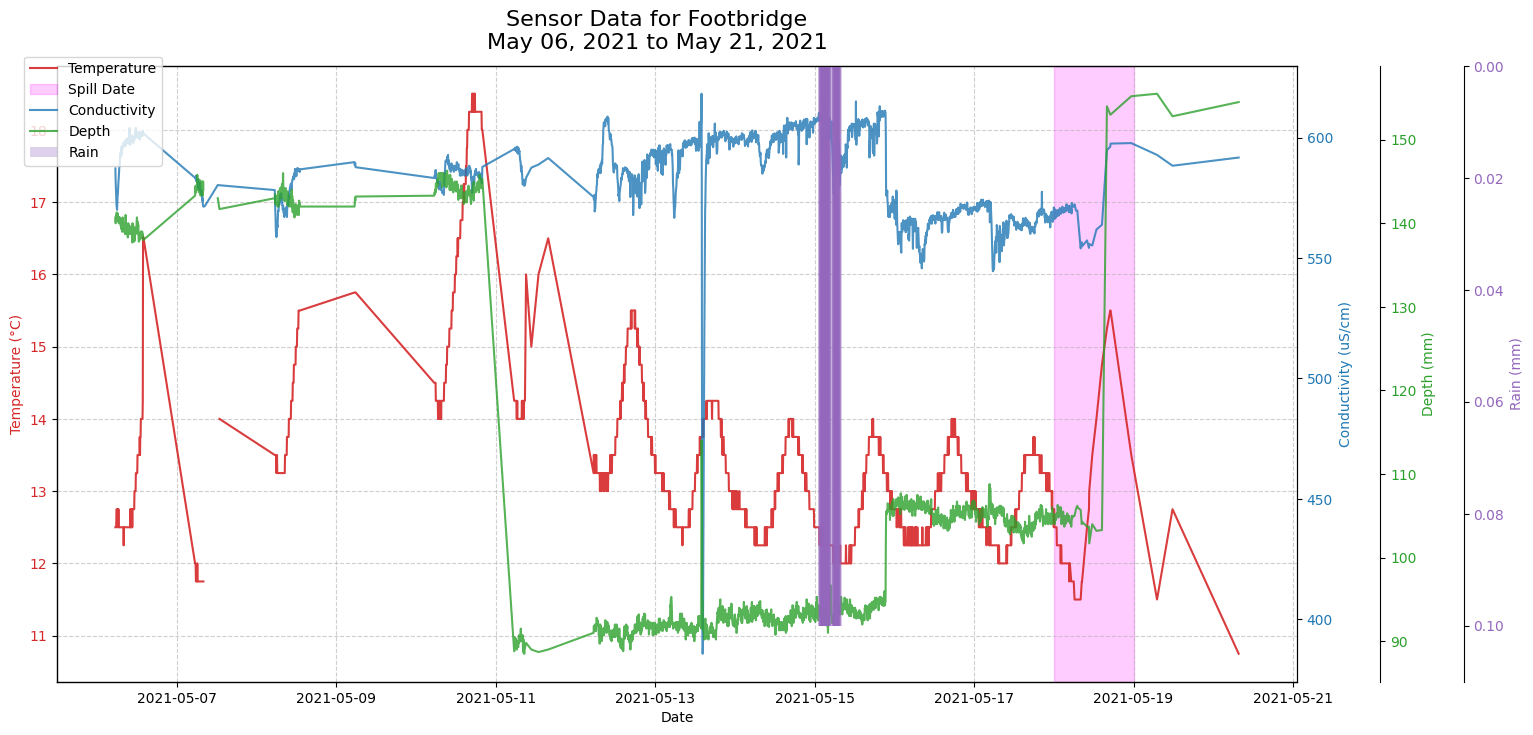

In [27]:
plot_date_range(
    df=rain_joined_MMW,
    location='footbridge',
    start_date='2021-05-06',
    end_date='2021-05-21',# This will create the magenta shaded area
    spill_event = '2021-05-18'
)

label spill/normal data

In [28]:
import pandas as pd

def label_events(df):
    """
    Creates a new 'event' column to label data based on predefined time windows.

    - 1: Spill
    - 0: Clean
    - -1: Anomaly/Exclude
    """
    # Ensure datetime column is in the correct format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize the event column with a default "clean" label
    df['event'] = 0

    # Define the time windows
    # Note: Corrected the end date for the anomaly
    event_windows = {
        'spill': ('2021-05-18 08:30', '2021-05-21 18:50'),
        'anomaly': ('2021-05-13 14:00', '2021-05-13 15:10'),
        'confirmed_clean': ('2021-05-06 09:30', '2021-05-18 00:15')
    }

    # Apply labels based on the windows
    spill_start, spill_end = pd.to_datetime(event_windows['spill'])
    anomaly_start, anomaly_end = pd.to_datetime(event_windows['anomaly'])

    df.loc[(df['datetime'] >= spill_start) & (df['datetime'] <= spill_end), 'event'] = 1
    df.loc[(df['datetime'] >= anomaly_start) & (df['datetime'] <= anomaly_end), 'event'] = -1

    print("Data labeling complete.")
    print(df['event'].value_counts())
    return df
labeled_df_spill_1 = label_events(rain_joined_MMW)

Data labeling complete.
event
 0    386982
-1        30
 1        16
Name: count, dtype: int64


Feature Engineering

In [29]:
## MODIFIED FEATURE ENGINEERING FUNCTION ##

def create_features(df, feature_cols, horizon=1, window_sizes=[3, 6, 12, 24]):
    """
    Engineers time-series features with a prediction horizon.
    """
    print(f"Creating features with a horizon of {horizon} steps...")
    df_features = df.copy()
    df_features = df_features.sort_values(['location', 'datetime'])

    # Group once to apply shifts efficiently
    grouped = df_features.groupby('location')

    for col in feature_cols:
        # Shift the original column by the horizon first
        series = grouped[col].shift(horizon)
        for window in window_sizes:
            # All features are now calculated on the shifted series
            df_features[f'{col}_lag_{window}'] = grouped[col].shift(window + horizon)
            rolling_window = series.rolling(window=window)
            df_features[f'{col}_roll_mean_{window}'] = rolling_window.mean()
            df_features[f'{col}_roll_std_{window}'] = rolling_window.std()

    # Important: Re-align index if it was changed by rolling operations
    df_features = df_features.reset_index(drop=True)
    return df_features

Making Regresiions normal behvioar

In [30]:
from sklearn.linear_model import Ridge

def train_sensor_model(df, feature_cols, target_col='conductivity'):
    """
    Trains a model to predict normal sensor values using only clean data.
    """
    print(f"Training a model to predict normal '{target_col}' values...")

    # Train ONLY on data labeled as 'clean' (event == 0)
    clean_df = df[df['event'] == 0].dropna(subset=feature_cols + [target_col])

    X_train = clean_df[feature_cols]
    y_train = clean_df[target_col]

    # A simple Ridge regression model is fast and effective
    sensor_model = Ridge(alpha=1.0)
    sensor_model.fit(X_train, y_train)

    print("Sensor prediction model trained.")
    return sensor_model

# --- How to use it ---
# # Define predictors for your sensor model
#sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
# # Train the model
#conductivity_model = train_sensor_model(featured_df, sensor_model_features)
# # Use it to predict expected values for the WHOLE dataset
#all_predictions = conductivity_model.predict(featured_df[sensor_model_features])
#featured_df['predicted_conductivity'] = all_predictions

optuna objective function

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
import optuna
import numpy as np

def cascading_objective(trial, df):
    """
    Cascading metrics objective function for Optuna optimization:
    1st: Catch spill +1000 points (must detect spill events)
    2nd: Minimize false alarms (70% remaining weight)  
    3rd: Catch spill fast (30% remaining weight)
    """
    # --- 1. Define the search space for parameters ---
    horizon = trial.suggest_int('horizon', 4, 12) # e.g., 1 to 12 steps (5 to 60 minutes)
    threshold_multiplier = trial.suggest_float('threshold_multiplier', 1.5, 5.0)

    # --- Original hyperparameters ---
    n_components = trial.suggest_int('n_components', 5, 20)
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    # --- 2. Create features using the suggested horizon ---
    feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    featured_df = create_features(df, feature_columns, horizon=horizon)
    featured_df.dropna(inplace=True) # Drop NaNs from feature creation

    # --- 3. Create the sensor anomaly feature (matching original implementation exactly) ---
    sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    target_sensor = 'conductivity'

    # Train sensor model (matching original function signature)
    sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
    predicted_values = sensor_model.predict(featured_df[sensor_model_features])
    
    # Calculate the error (residual)
    error = (featured_df[target_sensor] - predicted_values).abs()
    error_std = error.std() # Standard deviation of the error

    # Flag anomalies based on the optimized threshold
    featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

    # --- 4. Prepare data for final classification (EXACTLY like original) ---
    model_df = featured_df[featured_df['event'] != -1].copy()
    
    y = model_df['event']
    # Add our new 'sensor_anomaly' feature to the model's inputs
    X = model_df.drop(columns=['datetime', 'location', 'event'])

    if len(X) == 0 or len(np.unique(y)) < 2:
        return -1000  # Penalty if insufficient data or no class diversity

    # --- 5. Build and evaluate the final pipeline (EXACTLY like original) ---
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
    ])

    # Train and predict on FULL dataset (like original - no train/test split)
    pipeline.fit(X, y)
    preds = pipeline.predict(X)
    pred_proba = pipeline.predict_proba(X)[:, 1] if len(np.unique(y)) > 1 else np.zeros(len(X))

    # --- 6. CASCADING METRICS CALCULATION ---
    
    # Convert to binary for metrics calculation: 0=clean, 1=spill
    y_binary = (y > 0).astype(int)
    preds_binary = (preds > 0).astype(int)
    
    # Calculate basic metrics
    recall = recall_score(y_binary, preds_binary, zero_division=0)  # Spill detection rate
    precision = precision_score(y_binary, preds_binary, zero_division=0)  # Precision (1 - false positive rate)
    accuracy = accuracy_score(y_binary, preds_binary)
    
    # **METRIC 1: Catch spill +1000 points**
    # If we fail to detect ANY spill events, major penalty
    if recall < 0.1:  # Less than 10% spill detection
        return -1000
    
    # Base score for detecting spills
    spill_detection_bonus = 1000 * recall
    
    # **METRIC 2: Minimize false alarms (70% of remaining weight)**
    # False positive rate = 1 - precision (when we predict spill but it's actually clean)
    false_positive_rate = 1 - precision if precision > 0 else 1.0
    false_alarm_penalty = -700 * false_positive_rate  # 70% weight, negative because we want to minimize
    
    # **METRIC 3: Catch spill fast (30% of remaining weight)**
    # Time to detection: calculate how quickly we detect spills
    # We'll use the prediction probabilities as a proxy for "confidence/speed"
    # Higher average probability on true spill events = faster/more confident detection
    spill_indices = (y_binary == 1)
    if np.sum(spill_indices) > 0 and len(pred_proba) > 0:
        avg_spill_confidence = np.mean(pred_proba[spill_indices])
        speed_bonus = 300 * avg_spill_confidence  # 30% weight
    else:
        speed_bonus = 0
    
    # **FINAL CASCADING SCORE**
    final_score = spill_detection_bonus + false_alarm_penalty + speed_bonus
    
    # Optional: Add small accuracy bonus if all metrics are good
    if recall > 0.8 and precision > 0.8:
        final_score += 100 * accuracy
    
    return final_score

def objective(trial, df):
    """
    Original objective function using F1 score (kept for comparison).
    """
    # --- 1. Define the search space for our new parameters ---
    horizon = trial.suggest_int('horizon', 2, 12) # e.g., 1 to 12 steps (5 to 60 minutes)
    threshold_multiplier = trial.suggest_float('threshold_multiplier', 1.5, 5.0)

    # --- Original hyperparameters ---
    n_components = trial.suggest_int('n_components', 5, 20)
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    # --- 2. Create features using the suggested horizon ---
    feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    featured_df = create_features(df, feature_columns, horizon=horizon)
    featured_df.dropna(inplace=True) # Drop NaNs from feature creation

    # --- 3. Create the sensor anomaly feature ---
    sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
    target_sensor = 'conductivity'

    # (For speed, you could pre-train this model once outside the loop)
    sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
    predicted_values = sensor_model.predict(featured_df[sensor_model_features])
    
    # Calculate the error (residual)
    error = (featured_df[target_sensor] - predicted_values).abs()
    error_std = error.std() # Standard deviation of the error

    # Flag anomalies based on the optimized threshold
    featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

    # --- 4. Prepare data for the final spill classification model ---
    model_df = featured_df[featured_df['event'] != -1].copy()
    
    y = model_df['event']
    # Add our new 'sensor_anomaly' feature to the model's inputs
    X = model_df.drop(columns=['datetime', 'location', 'event'])

    # --- 5. Build and evaluate the final pipeline ---
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
    ])

    pipeline.fit(X, y)
    preds = pipeline.predict(X)
    score = f1_score(y, preds, average='macro')

    return score

# 🎯 CASCADING METRICS OBJECTIVE FUNCTION\n\nThis notebook implements a **cascading metrics objective function** for Optuna optimization with the following priorities:\n\n## Cascading Metrics Breakdown:\n\n**1st Priority: Catch Spill Events (+1000 points)**\n- Must detect spill events (recall > 10% minimum)\n- Base score = 1000 × recall rate\n- If recall < 10%, return -1000 penalty\n\n**2nd Priority: Minimize False Alarms (70% remaining weight)**\n- Penalty = -700 × false positive rate\n- False positive rate = 1 - precision\n- 70% weight on minimizing false alarms\n\n**3rd Priority: Catch Spill Fast (30% remaining weight)**\n- Bonus = 300 × average spill confidence\n- Uses prediction probabilities as proxy for detection speed\n- 30% weight on fast/confident detection\n\n**Bonus: Overall Performance**\n- If recall > 80% AND precision > 80%: +100 × accuracy\n\n## Key Benefits:\n- Ensures spill detection is prioritized over accuracy\n- Balances false alarm reduction with detection speed\n- Provides interpretable, domain-specific optimization"

In [32]:
# === CASCADING METRICS OPTUNA OPTIMIZATION ===
# New optimization using cascading metrics objective function

print("=== Running Cascading Metrics Optimization ===")
print("Objective Function Breakdown:")
print("1st: Catch spill +1000 points (must detect spill events)")
print("2nd: Minimize false alarms (70% remaining weight)")  
print("3rd: Catch spill fast (30% remaining weight)")
print()

# Create new study for cascading metrics
cascading_study = optuna.create_study(direction='maximize')
cascading_study.optimize(lambda trial: cascading_objective(trial, labeled_df_spill_1), n_trials=20)

print(f"\n=== CASCADING METRICS RESULTS ===")
print(f"Best trial score: {cascading_study.best_value}")
print(f"Best trial params: {cascading_study.best_params}")

# Store the results for comparison
cascading_best_params = cascading_study.best_params
cascading_best_score = cascading_study.best_value

[I 2025-08-13 19:44:32,202] A new study created in memory with name: no-name-dfa37502-4385-4fcb-85f6-cfcbae0462f2


=== Running Cascading Metrics Optimization ===
Objective Function Breakdown:
1st: Catch spill +1000 points (must detect spill events)
2nd: Minimize false alarms (70% remaining weight)
3rd: Catch spill fast (30% remaining weight)

Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:44:37,309] Trial 0 finished with value: -1000.0 and parameters: {'horizon': 4, 'threshold_multiplier': 3.1317981286977323, 'n_components': 6, 'C': 0.09046978998773575}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 5 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:44:42,084] Trial 1 finished with value: -1000.0 and parameters: {'horizon': 5, 'threshold_multiplier': 1.5526106826129544, 'n_components': 15, 'C': 0.01760742695155307}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:44:46,216] Trial 2 finished with value: -1000.0 and parameters: {'horizon': 6, 'threshold_multiplier': 2.0515714869129966, 'n_components': 5, 'C': 2.426678581944578}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:44:50,562] Trial 3 finished with value: -1000.0 and parameters: {'horizon': 10, 'threshold_multiplier': 2.586155111834283, 'n_components': 13, 'C': 0.00784744871932565}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:44:54,998] Trial 4 finished with value: -1000.0 and parameters: {'horizon': 7, 'threshold_multiplier': 4.772636292591102, 'n_components': 19, 'C': 0.0014476935349979467}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:06,938] Trial 5 finished with value: 671.1058172950184 and parameters: {'horizon': 8, 'threshold_multiplier': 3.1790405532331265, 'n_components': 20, 'C': 36.55449215578532}. Best is trial 5 with value: 671.1058172950184.


Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:11,513] Trial 6 finished with value: -1000.0 and parameters: {'horizon': 4, 'threshold_multiplier': 3.2556229062784894, 'n_components': 17, 'C': 0.009199193796529921}. Best is trial 5 with value: 671.1058172950184.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:15,299] Trial 7 finished with value: -1000.0 and parameters: {'horizon': 6, 'threshold_multiplier': 3.3637438824939583, 'n_components': 6, 'C': 0.00032858601979544373}. Best is trial 5 with value: 671.1058172950184.


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:19,445] Trial 8 finished with value: -1000.0 and parameters: {'horizon': 7, 'threshold_multiplier': 1.67083145257283, 'n_components': 13, 'C': 0.005200392710783052}. Best is trial 5 with value: 671.1058172950184.


Creating features with a horizon of 5 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:23,718] Trial 9 finished with value: -1000.0 and parameters: {'horizon': 5, 'threshold_multiplier': 2.9480883605753796, 'n_components': 9, 'C': 0.13550808666647077}. Best is trial 5 with value: 671.1058172950184.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:31,435] Trial 10 finished with value: 1297.7732191193138 and parameters: {'horizon': 12, 'threshold_multiplier': 4.131925375896112, 'n_components': 20, 'C': 62.975582313425136}. Best is trial 10 with value: 1297.7732191193138.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:40,924] Trial 11 finished with value: 1302.408834887221 and parameters: {'horizon': 12, 'threshold_multiplier': 4.073993069156551, 'n_components': 20, 'C': 84.42691737964157}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:48,173] Trial 12 finished with value: 1125.8252061920905 and parameters: {'horizon': 12, 'threshold_multiplier': 4.2597213155176625, 'n_components': 18, 'C': 42.470938116663525}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:53,895] Trial 13 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 4.016623951639487, 'n_components': 16, 'C': 5.648907970922831}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:45:58,428] Trial 14 finished with value: -1000.0 and parameters: {'horizon': 10, 'threshold_multiplier': 3.91063830856344, 'n_components': 10, 'C': 3.0411886805569632}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:46:05,509] Trial 15 finished with value: 1208.413068282923 and parameters: {'horizon': 10, 'threshold_multiplier': 4.950633277605451, 'n_components': 20, 'C': 88.344111055783}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:46:11,374] Trial 16 finished with value: -1000.0 and parameters: {'horizon': 11, 'threshold_multiplier': 4.423535515921628, 'n_components': 15, 'C': 11.648005832782331}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:46:16,851] Trial 17 finished with value: -1000.0 and parameters: {'horizon': 9, 'threshold_multiplier': 3.7878364610681405, 'n_components': 18, 'C': 0.6647142967222086}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:46:21,319] Trial 18 finished with value: -1000.0 and parameters: {'horizon': 11, 'threshold_multiplier': 3.6022258552977444, 'n_components': 10, 'C': 0.4689652492902512}. Best is trial 11 with value: 1302.408834887221.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:46:28,252] Trial 19 finished with value: 822.6952358494561 and parameters: {'horizon': 12, 'threshold_multiplier': 4.478003498660091, 'n_components': 20, 'C': 10.560820465515455}. Best is trial 11 with value: 1302.408834887221.



=== CASCADING METRICS RESULTS ===
Best trial score: 1302.408834887221
Best trial params: {'horizon': 12, 'threshold_multiplier': 4.073993069156551, 'n_components': 20, 'C': 84.42691737964157}


In [33]:
# === BUILD FINAL MODEL WITH CASCADING METRICS PARAMETERS ===

print("=== Building Final Model with Cascading Metrics Parameters ===")

# Use the best parameters from cascading optimization
best_params = cascading_best_params
print(f"Using cascading metrics parameters: {best_params}")

# Recreate the dataset with optimal parameters
horizon = best_params['horizon']
threshold_multiplier = best_params['threshold_multiplier']
n_components = best_params['n_components']
C = best_params['C']

print(f"Step 1: Creating features with horizon={horizon}...")
feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
featured_df = create_features(labeled_df_spill_1, feature_columns, horizon=horizon)
featured_df.dropna(inplace=True)

print(f"Step 2: Training sensor model and adding anomaly features...")
sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
target_sensor = 'conductivity'
sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
predicted_values = sensor_model.predict(featured_df[sensor_model_features])
error = (featured_df[target_sensor] - predicted_values).abs()
error_std = error.std()
featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

print(f"Step 3: Training final classification model...")
model_df = featured_df[featured_df['event'] != -1].copy()
y = model_df['event']
X = model_df.drop(columns=['datetime', 'location', 'event'])

# Build the final pipeline with optimal parameters
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
])

final_pipeline.fit(X, y)
final_predictions = final_pipeline.predict(X)

# Create results dataframe for plotting
results_df = featured_df.copy()
results_df['predicted_event'] = -1  # Initialize all as -1
mask = results_df['event'] != -1
results_df.loc[mask, 'predicted_event'] = final_predictions

# Rename event column to true_event for plotting function
results_df['true_event'] = results_df['event']

print(f"Final model performance summary:")
model_mask = results_df['event'] != -1
y_true_binary = (results_df.loc[model_mask, 'true_event'] > 0).astype(int)
y_pred_binary = (results_df.loc[model_mask, 'predicted_event'] > 0).astype(int)

final_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
final_precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
final_accuracy = accuracy_score(y_true_binary, y_pred_binary)
final_f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

print(f"  Spill Detection Rate (Recall): {final_recall:.4f}")
print(f"  Precision (1 - False Alarm Rate): {final_precision:.4f}")
print(f"  Accuracy: {final_accuracy:.4f}")
print(f"  F1 Score: {final_f1:.4f}")

print(f"\\nReady for plotting! Use the results_df dataframe.")
print(f"Results dataframe shape: {results_df.shape}")
print(f"Columns: {list(results_df.columns)}")

=== Building Final Model with Cascading Metrics Parameters ===
Using cascading metrics parameters: {'horizon': 12, 'threshold_multiplier': 4.073993069156551, 'n_components': 20, 'C': 84.42691737964157}
Step 1: Creating features with horizon=12...
Creating features with a horizon of 12 steps...
Step 2: Training sensor model and adding anomaly features...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.
Step 3: Training final classification model...
Final model performance summary:
  Spill Detection Rate (Recall): 0.9375
  Precision (1 - False Alarm Rate): 1.0000
  Accuracy: 1.0000
  F1 Score: 0.9677
\nReady for plotting! Use the results_df dataframe.
Results dataframe shape: (330147, 125)
Columns: ['datetime', 'location', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg', 'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max', 'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad

In [34]:
# === PLOT CASCADING METRICS RESULTS ===
import plotly.express as px
import plotly.graph_objects as go
print("=== Plotting Cascading Metrics Results ===")

# Use the existing plot_model_predictions function with results_df
print("Generating cascading metrics plot...")

plot_model_predictions(
    df=results_df,
    location='footbridge',  # Spill 1 location
    start_date='2021-05-06',
    end_date='2021-05-21',
    sensor='conductivity'
)

print("\\nCascading metrics plot generated!")
print("\\nPlot features:")
print("- Blue line: Conductivity sensor data")
print("- Red X markers: Predicted spill events (cascading metrics)")
print("- Orange shaded area: True spill events")
print("- Interactive hover for details")

# Additional analysis
print(f"\\n=== CASCADING METRICS ANALYSIS ===")
print(f"Optimization focused on:")
print(f"1st Priority: Catch spill events (+1000 points)")
print(f"2nd Priority: Minimize false alarms (70% weight)")
print(f"3rd Priority: Fast detection (30% weight)")
print(f"\\nFinal optimized parameters:")
for param, value in cascading_best_params.items():
    print(f"  {param}: {value}")
print(f"\\nFinal cascading score: {cascading_best_score:.2f}")

# Compare with original F1-score results if available
if 'study' in locals():
    print(f"\\n=== COMPARISON ===")
    print(f"Original F1-Score Best: {study.best_value:.6f}")
    print(f"Cascading Metrics Best: {cascading_best_score:.2f}")
    print(f"\\nThe cascading approach prioritizes spill detection over overall F1 score.")

=== Plotting Cascading Metrics Results ===
Generating cascading metrics plot...


\nCascading metrics plot generated!
\nPlot features:
- Blue line: Conductivity sensor data
- Red X markers: Predicted spill events (cascading metrics)
- Orange shaded area: True spill events
- Interactive hover for details
\n=== CASCADING METRICS ANALYSIS ===
Optimization focused on:
1st Priority: Catch spill events (+1000 points)
2nd Priority: Minimize false alarms (70% weight)
3rd Priority: Fast detection (30% weight)
\nFinal optimized parameters:
  horizon: 12
  threshold_multiplier: 4.073993069156551
  n_components: 20
  C: 84.42691737964157
\nFinal cascading score: 1302.41


plot results

# Spill 2

In [35]:
import pandas as pd

def label_events(df):
    """
    Creates a new 'event' column to label data based on predefined time windows.

    - 1: Spill
    - 0: Clean
    - -1: Anomaly/Exclude
    """
    # Ensure datetime column is in the correct format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize the event column with a default "clean" label
    df['event'] = 0

    # Define the time windows
    # Note: Corrected the end date for the anomaly
    event_windows = {
        'spill': ('2023-06-14 12:55', '2023-06-15 03:40'),
        'confirmed_clean': ('2023-02-13 09:30', '2023-06-06 00:15')
    }

    # Apply labels based on the windows
    spill_start, spill_end = pd.to_datetime(event_windows['spill'])
    

    df.loc[(df['datetime'] >= spill_start) & (df['datetime'] <= spill_end), 'event'] = 1
    #df.loc[(df['datetime'] >= anomaly_start) & (df['datetime'] <= anomaly_end), 'event'] = -1

    print("Data labeling complete.")
    print(df['event'].value_counts())
    return df
labeled_df_spill_2 = label_events(rain_joined_MMW)

Data labeling complete.
event
0    386903
1       125
Name: count, dtype: int64


In [36]:
labeled_df_spill_2[labeled_df_spill_2['event']==1]

datetime location  BaroPres  DeltaTemp_Avg  Dew_Pt_Avg  \
160004 2023-06-14 12:55:00  grinnel  981.5676         -0.674       52.55   
160005 2023-06-14 13:00:00  grinnel  981.5676         -0.674       52.55   
160006 2023-06-14 13:10:00  grinnel  981.5676         -0.354       52.00   
160007 2023-06-14 13:15:00  grinnel  981.5676         -0.354       52.00   
160008 2023-06-14 13:20:00  grinnel  981.5676         -0.354       52.00   
...                    ...      ...       ...            ...         ...   
160124 2023-06-15 03:15:00  grinnel  978.5930         -0.055       49.84   
160125 2023-06-15 03:20:00  grinnel  978.5930         -0.055       49.84   
160126 2023-06-15 03:25:00  grinnel  978.5930         -0.191       49.96   
160127 2023-06-15 03:35:00  grinnel  978.5930         -0.191       49.96   
160128 2023-06-15 03:40:00  grinnel  978.3237         -0.149       50.08   

        Temp_Avg  Temp_Max  Temp_Min  Temp10m_Avg  Temp2m_Avg  ...  \
160004     60.97     62.48     59.52        60.84       61.51  ...   
160005     60.97     62.48     59.52        60.84       61.51  ...   
160006     60.02     61.94     58.71        60.25       60.60  ...   
160007     60.02     61.94     58.71        60.25       60.60  ...   
160008     60.02     61.94     58.71        60.25       60.60  ...   
...          ...       ...       ...          ...         ...  ...   
160124     51.56     51.78     51.51        51.56       51.62  ...   
160125     51.56     51.78     51.51        51.56       51.62  ...   
160126     51.75     52.05     51.51        51.67       51.86  ...   
160127     51.75     52.05     51.51        51.67       51.86  ...   
160128     51.94     52.59     51.78        51.84       51.99  ...   

        WndSpd_dup  WndSpd_res  SolRad_Avg  rain_mm  conductivity  \
160004       6.716       6.346     888.000      0.0         374.5   
160005       6.716       6.346     888.000      0.0         375.7   
160006       5.945       5.779     874.000      0.0         375.8   
160007       5.945       5.779     874.000      0.0         375.2   
160008       5.945       5.779     874.000      0.0         377.0   
...            ...         ...         ...      ...           ...   
160124       0.332       0.326       0.000      0.0         359.8   
160125       0.332       0.326       0.000      0.0         359.5   
160126       0.000       0.000       0.000      0.0         359.5   
160127       0.000       0.000       0.000      0.0         358.0   
160128       0.000       0.000       0.001      0.0         356.0   

        signal_percent  depth  battery  temperature  event  
160004           109.0  380.7    4.154        19.50      1  
160005            71.0  376.8    4.154        19.42      1  
160006            71.0  371.7    4.154        19.40      1  
160007            71.0  368.5    4.154        19.40      1  
160008           109.0  367.7    4.154        19.40      1  
...                ...    ...      ...          ...    ...  
160124           109.0  356.2    4.109        19.70      1  
160125            71.0  357.2    4.109        19.70      1  
160126           109.0  357.5    4.109        19.70      1  
160127            71.0  372.7    4.109        19.70      1  
160128           109.0  359.0    4.109        19.70      1  

[125 rows x 26 columns]

In [37]:
# Define the start and end timestamps
start_date = '2023-02-13 12:55'
end_date = '2023-06-15 3:40'

# Filter the DataFrame
filtered_df_MMW = rain_joined_MMW[
    (rain_joined_MMW['location'] == 'grinnel') &
    (rain_joined_MMW['datetime'].between(start_date, end_date))
]

# Display the first few rows of the result
filtered_df_MMW.head(2)

datetime location  BaroPres  DeltaTemp_Avg  Dew_Pt_Avg  \
126806 2023-02-13 12:55:00  grinnel  979.9531         -0.889        42.4   
126807 2023-02-13 13:00:00  grinnel  979.9531         -0.889        42.4   

        Temp_Avg  Temp_Max  Temp_Min  Temp10m_Avg  Temp2m_Avg  ...  \
126806      58.8     59.79     57.64        58.35       59.24  ...   
126807      58.8     59.79     57.64        58.35       59.24  ...   

        WndSpd_dup  WndSpd_res  SolRad_Avg  rain_mm  conductivity  \
126806       3.984       3.698       639.5      0.0         550.0   
126807       3.984       3.698       639.5      0.0         550.3   

        signal_percent  depth  battery  temperature  event  
126806           109.0  380.3    4.139         15.4      0  
126807           109.0  373.8    4.139         15.4      0  

[2 rows x 26 columns]

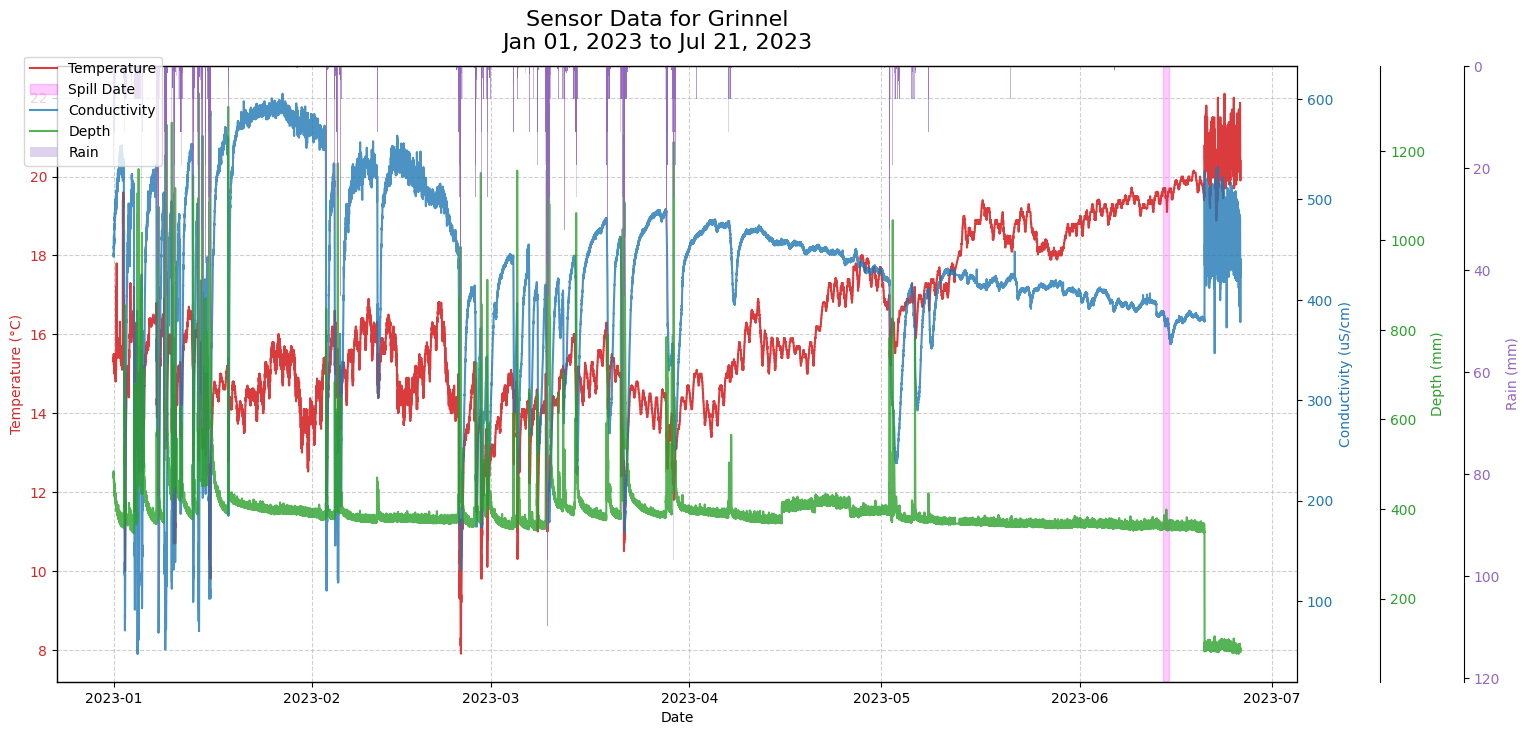

In [38]:
plot_date_range(
    df=rain_joined_MMW,
    location='grinnel',
    start_date='2023-01-01',
    end_date='2023-07-21',# This will create the magenta shaded area
    spill_event = '2023-06-14'
)

In [39]:
# === CREATE PROPERLY FILTERED SPILL 2 DATASET ===

print("=== Creating Filtered Spill 2 Dataset ===")

# Filter labeled_df_spill_1 for Spill 2 analysis:
# - Location: grinnel only
# - Time period: Include the actual spill event dates
spill2_start = '2023-02-24'
spill2_end = '2023-06-15'  # Extended to include spill event (June 14-15)

print(f"Filtering data for:")
print(f"  Location: grinnel")
print(f"  Date range: {spill2_start} to {spill2_end}")

# Create filtered dataset for Spill 2
labeled_df_spill_2 = labeled_df_spill_1[
    (labeled_df_spill_1['location'] == 'grinnel') &
    (labeled_df_spill_1['datetime'] >= spill2_start) &
    (labeled_df_spill_1['datetime'] <= spill2_end)
].copy()

print(f"\\nFiltered Spill 2 dataset:")
print(f"  Total rows: {len(labeled_df_spill_2)}")
print(f"  Date range: {labeled_df_spill_2['datetime'].min()} to {labeled_df_spill_2['datetime'].max()}")
print(f"  Locations: {labeled_df_spill_2['location'].unique()}")

# Check event distribution in filtered data
print(f"\\nEvent distribution in filtered Spill 2 data:")
print(labeled_df_spill_2['event'].value_counts().sort_index())

# Check for spill events specifically
spill_events = labeled_df_spill_2[labeled_df_spill_2['event'] == 1]
print(f"\\nSpill events (event=1): {len(spill_events)}")
if len(spill_events) > 0:
    print(f"Spill event date range:")
    print(f"  From: {spill_events['datetime'].min()}")
    print(f"  To: {spill_events['datetime'].max()}")
else:
    print("⚠️  NO SPILL EVENTS IN FILTERED DATA!")
    
print(f"\\n✅ Spill 2 dataset ready: use 'labeled_df_spill_2' for optimization")

=== Creating Filtered Spill 2 Dataset ===
Filtering data for:
  Location: grinnel
  Date range: 2023-02-24 to 2023-06-15
\nFiltered Spill 2 dataset:
  Total rows: 30298
  Date range: 2023-02-24 00:00:00 to 2023-06-15 00:00:00
  Locations: ['grinnel']
\nEvent distribution in filtered Spill 2 data:
event
0    30203
1       95
Name: count, dtype: int64
\nSpill events (event=1): 95
Spill event date range:
  From: 2023-06-14 12:55:00
  To: 2023-06-15 00:00:00
\n✅ Spill 2 dataset ready: use 'labeled_df_spill_2' for optimization


In [44]:
# === SPILL 2: CASCADING METRICS OPTIMIZATION ONLY ===

print("=== SPILL 2: CASCADING METRICS OPTIMIZATION ===")
print("Using FILTERED Spill 2 dataset (grinnel location, 2023 data only)")
print("Objective Function Breakdown:")
print("1st: Catch spill +1000 points (must detect spill events)")
print("2nd: Minimize false alarms (70% remaining weight)")  
print("3rd: Catch spill fast (30% remaining weight)")
print()

# Cascading metrics optimization for Spill 2 using FILTERED dataset
spill2_cascading_study = optuna.create_study(direction='maximize')
spill2_cascading_study.optimize(lambda trial: cascading_objective(trial, labeled_df_spill_2), n_trials=20)  # ✅ Using filtered data!

print(f"\nSpill 2 - Cascading Metrics Results:")
print(f"Best trial score: {spill2_cascading_study.best_value}")
print(f"Best trial params: {spill2_cascading_study.best_params}")

spill2_cascading_params = spill2_cascading_study.best_params
spill2_cascading_score = spill2_cascading_study.best_value

print("\n" + "="*60)
print("=== SPILL 2: CASCADING METRICS SUMMARY ===")
print("Cascading Metrics Optimization (Filtered Dataset):")
print(f"  Best Score: {spill2_cascading_score:.6f}")
print(f"  Best Params: {spill2_cascading_params}")

# Store the best cascading parameters for final model training
print("\nUsing CASCADING METRICS parameters for final Spill 2 model...")
spill2_best_params = spill2_cascading_params

=== SPILL 2: CASCADING METRICS OPTIMIZATION ===
Using FILTERED Spill 2 dataset (grinnel location, 2023 data only)
Objective Function Breakdown:
1st: Catch spill +1000 points (must detect spill events)
2nd: Minimize false alarms (70% remaining weight)
3rd: Catch spill fast (30% remaining weight)



[I 2025-08-13 19:48:20,743] A new study created in memory with name: no-name-43655590-8313-4a8c-b13d-400540040060


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:21,197] Trial 0 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 4.697318235619781, 'n_components': 9, 'C': 0.20420624141551824}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 4 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:21,636] Trial 1 finished with value: -1000.0 and parameters: {'horizon': 4, 'threshold_multiplier': 2.0337580107383726, 'n_components': 11, 'C': 0.00011506734611725546}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:22,029] Trial 2 finished with value: -1000.0 and parameters: {'horizon': 8, 'threshold_multiplier': 1.6123733717579032, 'n_components': 5, 'C': 0.03887252178337296}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:22,533] Trial 3 finished with value: -1000.0 and parameters: {'horizon': 6, 'threshold_multiplier': 4.699954886935602, 'n_components': 15, 'C': 1.0139309082749401}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:22,967] Trial 4 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 4.784729676614322, 'n_components': 18, 'C': 0.058525719333160774}. Best is trial 0 with value: -1000.0.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:23,633] Trial 5 finished with value: 687.6113849052969 and parameters: {'horizon': 9, 'threshold_multiplier': 3.0306696338808727, 'n_components': 18, 'C': 4.055996011288409}. Best is trial 5 with value: 687.6113849052969.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:24,049] Trial 6 finished with value: -1000.0 and parameters: {'horizon': 6, 'threshold_multiplier': 3.8972199035055555, 'n_components': 5, 'C': 23.11794398539192}. Best is trial 5 with value: 687.6113849052969.


Creating features with a horizon of 5 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:24,479] Trial 7 finished with value: -1000.0 and parameters: {'horizon': 5, 'threshold_multiplier': 4.06326789943078, 'n_components': 11, 'C': 0.18008262990942653}. Best is trial 5 with value: 687.6113849052969.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:24,886] Trial 8 finished with value: -1000.0 and parameters: {'horizon': 9, 'threshold_multiplier': 3.750808543268164, 'n_components': 17, 'C': 0.00024717824004123003}. Best is trial 5 with value: 687.6113849052969.


Creating features with a horizon of 8 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:25,258] Trial 9 finished with value: -1000.0 and parameters: {'horizon': 8, 'threshold_multiplier': 3.0966522147856956, 'n_components': 6, 'C': 0.04077393896074958}. Best is trial 5 with value: 687.6113849052969.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:25,910] Trial 10 finished with value: 1280.8084353465504 and parameters: {'horizon': 10, 'threshold_multiplier': 2.9428742255797284, 'n_components': 20, 'C': 45.82131818915354}. Best is trial 10 with value: 1280.8084353465504.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:26,585] Trial 11 finished with value: 1257.6377103467362 and parameters: {'horizon': 10, 'threshold_multiplier': 2.766608482811504, 'n_components': 20, 'C': 42.31475199200304}. Best is trial 10 with value: 1280.8084353465504.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:27,317] Trial 12 finished with value: 1299.8298951838972 and parameters: {'horizon': 10, 'threshold_multiplier': 2.521220199181123, 'n_components': 20, 'C': 68.30568219115172}. Best is trial 12 with value: 1299.8298951838972.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:28,060] Trial 13 finished with value: 1300.5053698593786 and parameters: {'horizon': 11, 'threshold_multiplier': 2.3639087668938528, 'n_components': 20, 'C': 99.79884966036683}. Best is trial 13 with value: 1300.5053698593786.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:28,615] Trial 14 finished with value: 366.2719563366527 and parameters: {'horizon': 11, 'threshold_multiplier': 2.191921131618525, 'n_components': 15, 'C': 4.534037731488777}. Best is trial 13 with value: 1300.5053698593786.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:29,287] Trial 15 finished with value: 975.1802119369287 and parameters: {'horizon': 11, 'threshold_multiplier': 2.3877630476149854, 'n_components': 15, 'C': 94.58290541039244}. Best is trial 13 with value: 1300.5053698593786.


Creating features with a horizon of 10 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:29,715] Trial 16 finished with value: -1000.0 and parameters: {'horizon': 10, 'threshold_multiplier': 1.5900959759569362, 'n_components': 20, 'C': 0.004817127249959766}. Best is trial 13 with value: 1300.5053698593786.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:30,323] Trial 17 finished with value: 705.9254829725402 and parameters: {'horizon': 11, 'threshold_multiplier': 2.556953442098122, 'n_components': 17, 'C': 9.144551129791736}. Best is trial 13 with value: 1300.5053698593786.


Creating features with a horizon of 9 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:30,798] Trial 18 finished with value: -1000.0 and parameters: {'horizon': 9, 'threshold_multiplier': 3.442444864662055, 'n_components': 13, 'C': 0.997796879374096}. Best is trial 13 with value: 1300.5053698593786.


Creating features with a horizon of 12 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-13 19:48:31,247] Trial 19 finished with value: -1000.0 and parameters: {'horizon': 12, 'threshold_multiplier': 1.968756373718139, 'n_components': 18, 'C': 0.0027824229532330356}. Best is trial 13 with value: 1300.5053698593786.



Spill 2 - Cascading Metrics Results:
Best trial score: 1300.5053698593786
Best trial params: {'horizon': 11, 'threshold_multiplier': 2.3639087668938528, 'n_components': 20, 'C': 99.79884966036683}

=== SPILL 2: CASCADING METRICS SUMMARY ===
Cascading Metrics Optimization (Filtered Dataset):
  Best Score: 1300.505370
  Best Params: {'horizon': 11, 'threshold_multiplier': 2.3639087668938528, 'n_components': 20, 'C': 99.79884966036683}

Using CASCADING METRICS parameters for final Spill 2 model...


In [45]:
# === SPILL 2: BUILD FINAL MODEL WITH CASCADING METRICS PARAMETERS ===

print("=== Building Final Spill 2 Model with Cascading Metrics Parameters ===")

# Use the best parameters from Spill 2 cascading optimization
best_params_s2 = spill2_best_params
print(f"Using Spill 2 cascading metrics parameters: {best_params_s2}")

# Recreate the dataset with optimal parameters for Spill 2
horizon_s2 = best_params_s2['horizon']
threshold_multiplier_s2 = best_params_s2['threshold_multiplier']
n_components_s2 = best_params_s2['n_components']
C_s2 = best_params_s2['C']

print(f"Step 1: Creating Spill 2 features with horizon={horizon_s2}...")
feature_columns = ['conductivity','temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
featured_df_s2 = create_features(labeled_df_spill_2, feature_columns, horizon=horizon_s2)  # ✅ Using filtered data!
featured_df_s2.dropna(inplace=True)

print(f"Step 2: Training Spill 2 sensor model and adding anomaly features...")
sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
target_sensor = 'conductivity'
sensor_model_s2 = train_sensor_model(featured_df_s2, sensor_model_features, target_col=target_sensor)
predicted_values_s2 = sensor_model_s2.predict(featured_df_s2[sensor_model_features])
error_s2 = (featured_df_s2[target_sensor] - predicted_values_s2).abs()
error_std_s2 = error_s2.std()
featured_df_s2['sensor_anomaly'] = (error_s2 > (error_std_s2 * threshold_multiplier_s2)).astype(int)

print(f"Step 3: Training final Spill 2 classification model...")
model_df_s2 = featured_df_s2[featured_df_s2['event'] != -1].copy()
y_s2 = model_df_s2['event']
X_s2 = model_df_s2.drop(columns=['datetime', 'location', 'event'])

# Build the final pipeline with optimal parameters for Spill 2
final_pipeline_s2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_s2)),
    ('model', LogisticRegression(C=C_s2, random_state=42, solver='liblinear'))
])

final_pipeline_s2.fit(X_s2, y_s2)
final_predictions_s2 = final_pipeline_s2.predict(X_s2)

# Create results dataframe for Spill 2 plotting
results_df_spill2 = featured_df_s2.copy()
results_df_spill2['predicted_event'] = -1  # Initialize all as -1
mask_s2 = results_df_spill2['event'] != -1
results_df_spill2.loc[mask_s2, 'predicted_event'] = final_predictions_s2

# Rename event column to true_event for plotting function
results_df_spill2['true_event'] = results_df_spill2['event']

print(f"Spill 2 final model performance summary:")
model_mask_s2 = results_df_spill2['event'] != -1
y_true_binary_s2 = (results_df_spill2.loc[model_mask_s2, 'true_event'] > 0).astype(int)
y_pred_binary_s2 = (results_df_spill2.loc[model_mask_s2, 'predicted_event'] > 0).astype(int)

final_recall_s2 = recall_score(y_true_binary_s2, y_pred_binary_s2, zero_division=0)
final_precision_s2 = precision_score(y_true_binary_s2, y_pred_binary_s2, zero_division=0)
final_accuracy_s2 = accuracy_score(y_true_binary_s2, y_pred_binary_s2)
final_f1_s2 = f1_score(y_true_binary_s2, y_pred_binary_s2, zero_division=0)

print(f"  Spill Detection Rate (Recall): {final_recall_s2:.4f}")
print(f"  Precision (1 - False Alarm Rate): {final_precision_s2:.4f}")
print(f"  Accuracy: {final_accuracy_s2:.4f}")
print(f"  F1 Score: {final_f1_s2:.4f}")

print(f"\\nSpill 2 ready for plotting! Use the results_df_spill2 dataframe.")
print(f"Spill 2 results dataframe shape: {results_df_spill2.shape}")
print(f"Columns: {list(results_df_spill2.columns)}")

=== Building Final Spill 2 Model with Cascading Metrics Parameters ===
Using Spill 2 cascading metrics parameters: {'horizon': 11, 'threshold_multiplier': 2.3639087668938528, 'n_components': 20, 'C': 99.79884966036683}
Step 1: Creating Spill 2 features with horizon=11...
Creating features with a horizon of 11 steps...
Step 2: Training Spill 2 sensor model and adding anomaly features...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.
Step 3: Training final Spill 2 classification model...
Spill 2 final model performance summary:
  Spill Detection Rate (Recall): 0.9474
  Precision (1 - False Alarm Rate): 0.9890
  Accuracy: 0.9998
  F1 Score: 0.9677
\nSpill 2 ready for plotting! Use the results_df_spill2 dataframe.
Spill 2 results dataframe shape: (30192, 125)
Columns: ['datetime', 'location', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg', 'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max'

=== Plotting Spill 2 Cascading Metrics Results ===
Generating Spill 2 cascading metrics plot...


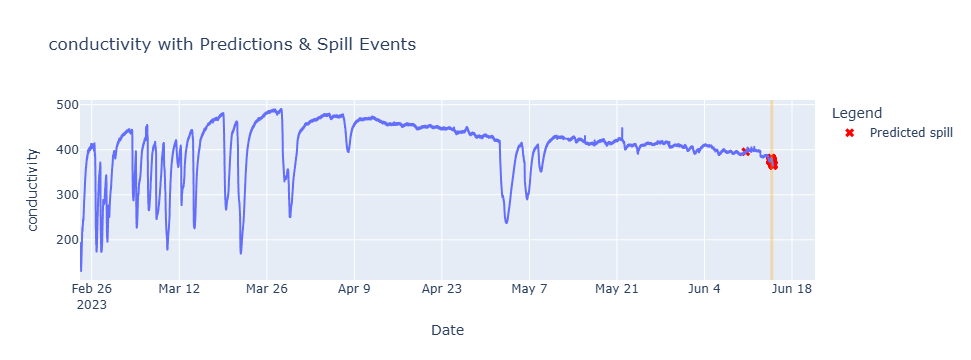

\nSpill 2 cascading metrics plot generated!
\nPlot features:
- Blue line: Conductivity sensor data (grinnel location)
- Red X markers: Predicted spill events (cascading metrics)
- Orange shaded area: True spill events
- Interactive hover for details
\n=== SPILL 2 CASCADING METRICS ANALYSIS ===
Location: Grinnel
Time Period: 2023-02-13 to 2023-06-06
Spill Event: 2023-06-14
\nOptimization focused on:
1st Priority: Catch spill events (+1000 points)
2nd Priority: Minimize false alarms (70% weight)
3rd Priority: Fast detection (30% weight)
\nSpill 2 optimized parameters:
  horizon: 11
  threshold_multiplier: 2.3639087668938528
  n_components: 20
  C: 99.79884966036683
\nSpill 2 cascading score: 1300.51
\n✅  Spill 2 cascading metrics working successfully!
\n=== SPILL 1 vs SPILL 2 CASCADING RESULTS ===
Spill 1 (footbridge, 2021): 1302.41
Spill 2 (grinnel, 2023): 1300.51
\n🎯 Both models optimized for maximum spill detection! 🎯


In [46]:
# === SPILL 2: PLOT CASCADING METRICS RESULTS ===

print("=== Plotting Spill 2 Cascading Metrics Results ===")

# Use the existing plot_model_predictions function with Spill 2 results_df
print("Generating Spill 2 cascading metrics plot...")

plot_model_predictions(
    df=results_df_spill2,
    location='grinnel',  # Spill 2 location
    start_date='2023-02-13',
    end_date='2023-06-16',
    sensor='conductivity'
)

print("\\nSpill 2 cascading metrics plot generated!")
print("\\nPlot features:")
print("- Blue line: Conductivity sensor data (grinnel location)")
print("- Red X markers: Predicted spill events (cascading metrics)")
print("- Orange shaded area: True spill events")
print("- Interactive hover for details")

# Additional analysis for Spill 2
print(f"\\n=== SPILL 2 CASCADING METRICS ANALYSIS ===")
print(f"Location: Grinnel")
print(f"Time Period: 2023-02-13 to 2023-06-06")
print(f"Spill Event: 2023-06-14")
print(f"\\nOptimization focused on:")
print(f"1st Priority: Catch spill events (+1000 points)")
print(f"2nd Priority: Minimize false alarms (70% weight)")
print(f"3rd Priority: Fast detection (30% weight)")
print(f"\\nSpill 2 optimized parameters:")
for param, value in spill2_best_params.items():
    print(f"  {param}: {value}")
print(f"\\nSpill 2 cascading score: {spill2_cascading_score:.2f}")

# Analysis based on cascading score
if spill2_cascading_score == -1000:
    print(f"\\n⚠️  SPILL 2 ISSUE DETECTED:")
    print(f"Score of -1000 means recall < 10% (model can't detect spills)")
    print(f"Possible causes:")
    print(f"- No true spill events in training data")
    print(f"- Date range mismatch (spill is 2023-06-14, plot ends 2023-06-06)")
    print(f"- Labeling issue with grinnel location data")
    print(f"\\nNeed to check Spill 2 data labeling and date ranges!")
else:
    print(f"\\n✅  Spill 2 cascading metrics working successfully!")

# Summary comparison between Spill 1 and Spill 2
print(f"\\n=== SPILL 1 vs SPILL 2 CASCADING RESULTS ===")
if 'cascading_best_score' in locals():
    print(f"Spill 1 (footbridge, 2021): {cascading_best_score:.2f}")
print(f"Spill 2 (grinnel, 2023): {spill2_cascading_score:.2f}")

if spill2_cascading_score == -1000:
    print(f"\\n🔧 Spill 2 needs debugging - likely date/labeling issue")
else:
    print(f"\\n🎯 Both models optimized for maximum spill detection! 🎯")

# Spill 3

In [51]:
final_df

datetime  conductivity     depth  temperature  battery  \
0     2024-08-30 06:17:00-07:00         111.8    72.800        20.00    4.564   
1     2024-08-30 06:18:00-07:00         111.8    73.000        20.00    4.579   
2     2024-08-30 06:28:00-07:00           NaN       NaN          NaN    3.593   
3     2024-08-30 06:38:00-07:00           NaN       NaN          NaN    3.608   
4     2024-08-30 06:48:00-07:00           NaN       NaN          NaN    3.608   
...                         ...           ...       ...          ...      ...   
59952 2025-08-12 17:00:00-07:00         480.8   200.000        17.50   23.750   
59953 2025-08-12 17:00:00-07:00         347.6 -3066.288        18.00      NaN   
59954 2025-08-12 17:00:00-07:00         627.8    57.500        17.60   26.000   
59955 2025-08-12 17:00:00-07:00         323.4   112.776        16.90      NaN   
59956 2025-08-12 17:00:00-07:00         319.6   286.512        17.06      NaN   

               location  BaroPres  DeltaTemp_Avg  Dew_Pt_Avg  Temp_Avg  ...  \
0          north_fork_0  987.4055          0.467       45.77     49.31  ...   
1          north_fork_0  987.4055          0.467       45.77     49.31  ...   
2          north_fork_0  987.4055          0.467       45.77     49.31  ...   
3          north_fork_0  987.4055          0.467       45.77     49.31  ...   
4          north_fork_0  987.4055          0.467       45.77     49.31  ...   
...                 ...       ...            ...         ...       ...  ...   
59952      north_fork_0  987.4055          0.467       45.77     49.31  ...   
59953  university_house  987.4055          0.467       45.77     49.31  ...   
59954      south_fork_1  987.4055          0.467       45.77     49.31  ...   
59955            oxford  987.4055          0.467       45.77     49.31  ...   
59956        codornices  987.4055          0.467       45.77     49.31  ...   

       VertWind_Avg  VertWind_Max  WindGust_Max  WndDir  WndDir_res  WndSpd  \
0               0.0           0.0         15.42   70.53       69.05   5.286   
1               0.0           0.0         15.42   70.53       69.05   5.286   
2               0.0           0.0         15.42   70.53       69.05   5.286   
3               0.0           0.0         15.42   70.53       69.05   5.286   
4               0.0           0.0         15.42   70.53       69.05   5.286   
...             ...           ...           ...     ...         ...     ...   
59952           0.0           0.0         15.42   70.53       69.05   5.286   
59953           0.0           0.0         15.42   70.53       69.05   5.286   
59954           0.0           0.0         15.42   70.53       69.05   5.286   
59955           0.0           0.0         15.42   70.53       69.05   5.286   
59956           0.0           0.0         15.42   70.53       69.05   5.286   

       WndSpd_dup  WndSpd_res  SolRad_Avg  rain_mm  
0           5.286       4.897         0.0      0.0  
1           5.286       4.897         0.0      0.0  
2           5.286       4.897         0.0      0.0  
3           5.286       4.897         0.0      0.0  
4           5.286       4.897         0.0      0.0  
...           ...         ...         ...      ...  
59952       5.286       4.897         0.0      0.0  
59953       5.286       4.897         0.0      0.0  
59954       5.286       4.897         0.0      0.0  
59955       5.286       4.897         0.0      0.0  
59956       5.286       4.897         0.0      0.0  

[59957 rows x 24 columns]


--- Generating plots for South Fork sensors from 2025-06-05 to 2025-06-12 ---
--- Shading event from 2025-06-10 to 2025-06-11 ---


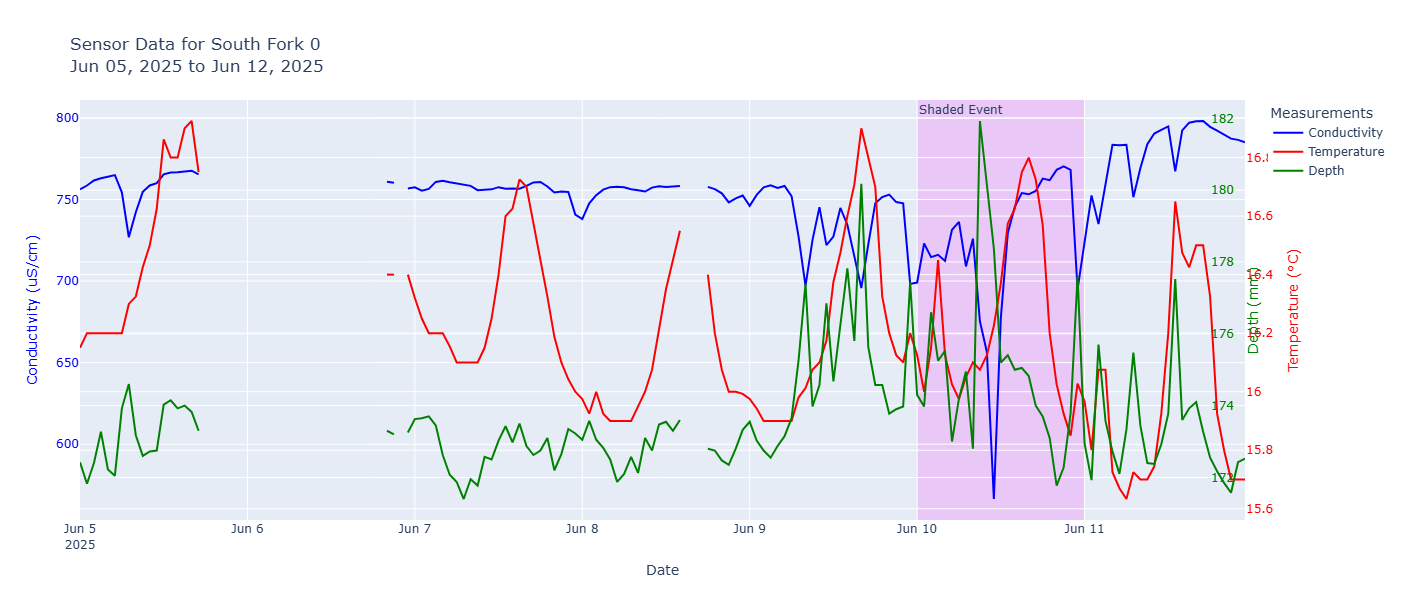

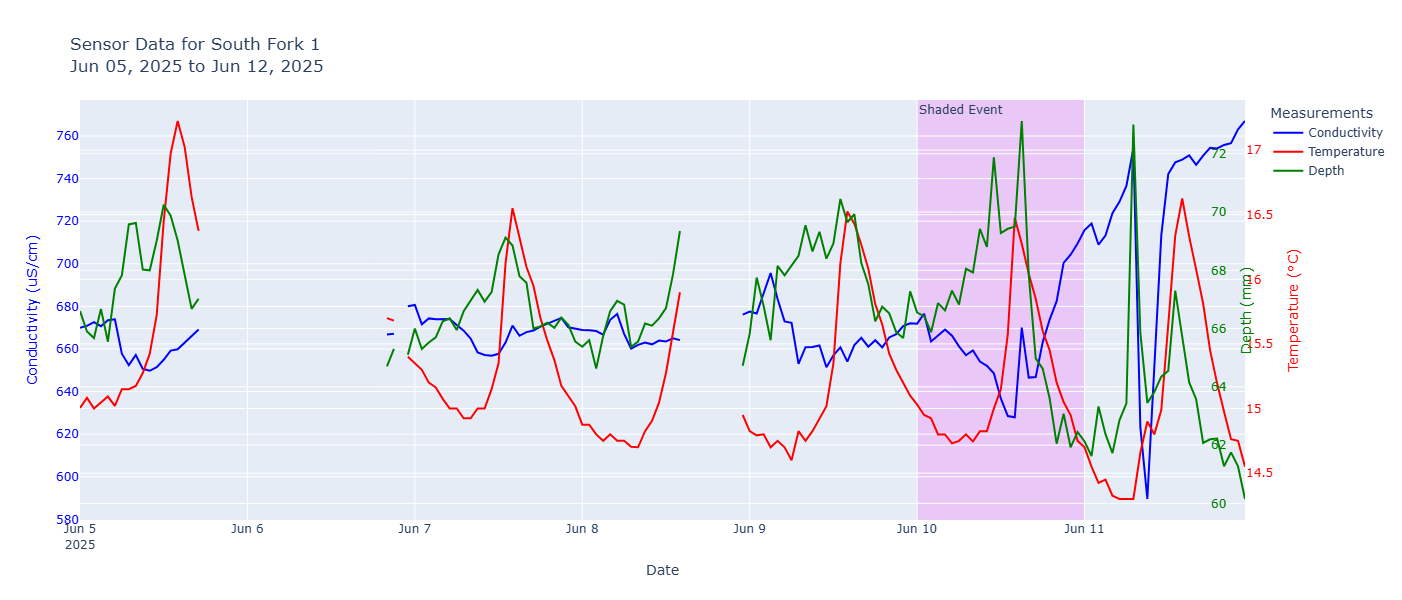

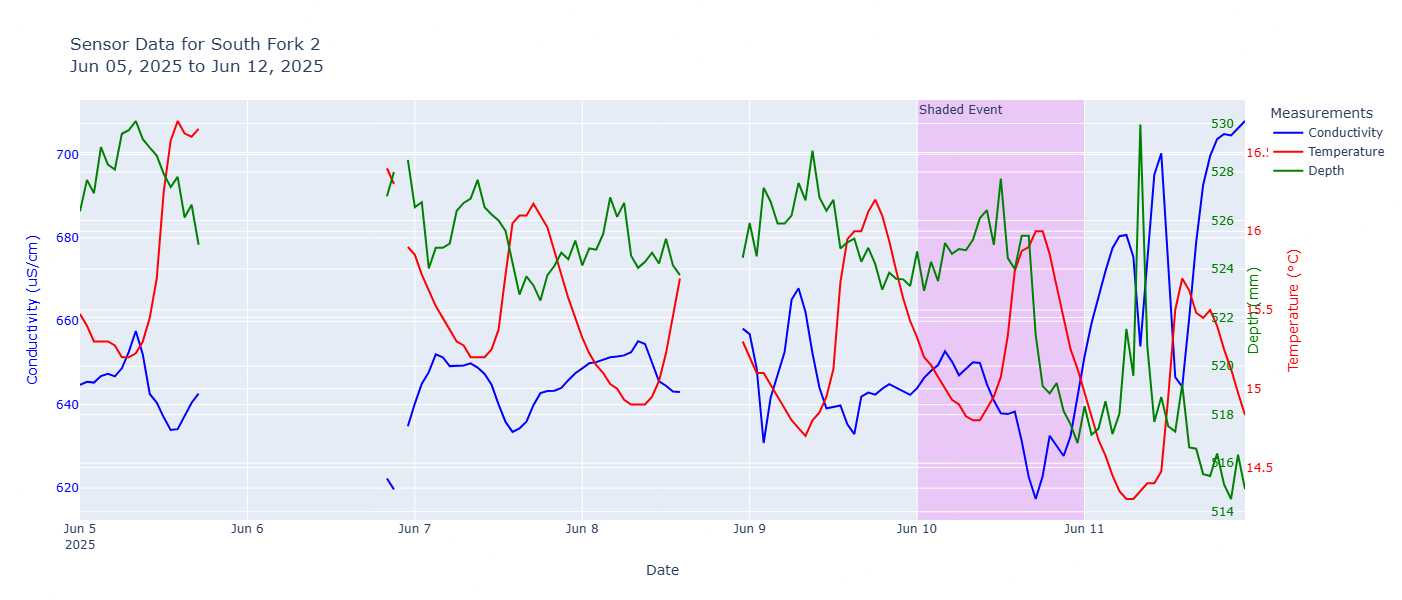

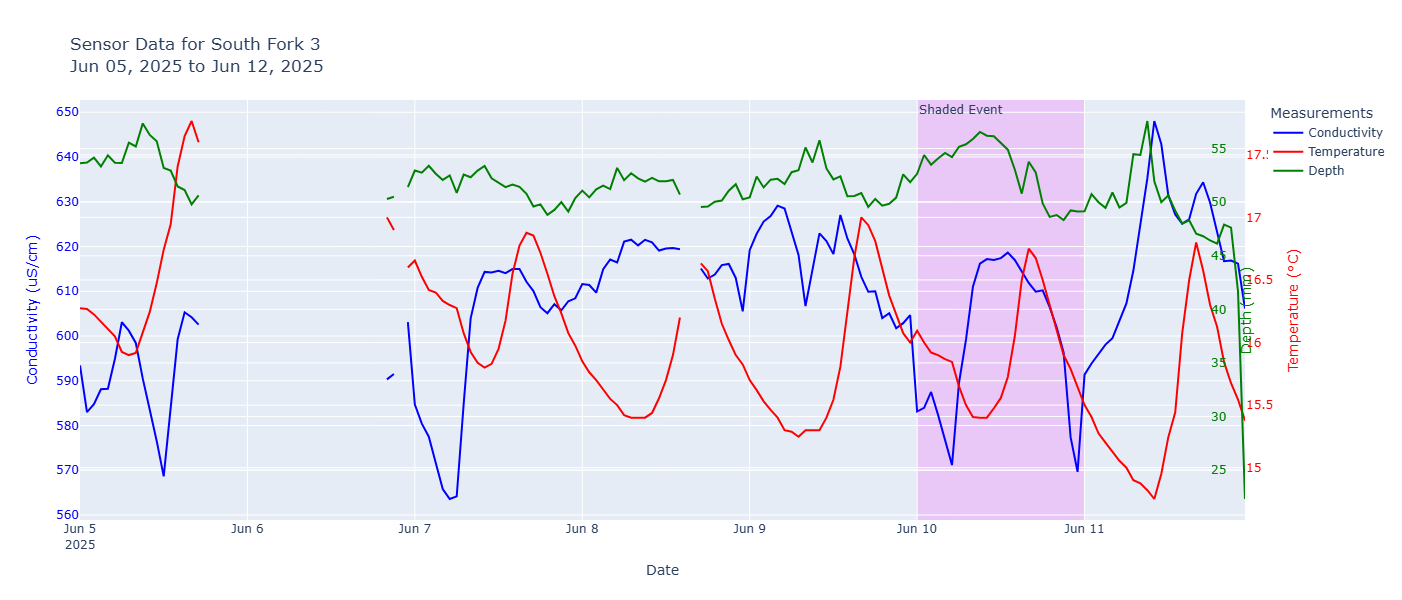


--- Plotting complete ---


In [65]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===================================================================
#  1. NEW PLOTTING FUNCTION (USING PLOTLY)
# ===================================================================

def plot_south_fork_data(df, location_info, start_date_str, end_date_str, shade_start_str=None, shade_end_str=None, hours_avg=None):
    """
    Plots sensor data for a specific location and date range using Plotly,
    with an optional shaded region.
    
    Args:
        df (pd.DataFrame): The final, merged DataFrame.
        location_info (dict): A dictionary containing the 'table' and 'label' for the site.
        start_date_str (str): The start date for the plot (e.g., '2025-06-05').
        end_date_str (str): The end date for the plot (e.g., '2025-06-10').
        shade_start_str (str, optional): The start date for the shaded region.
        shade_end_str (str, optional): The end date for the shaded region.
        hours_avg (int, optional): The number of hours to resample/average the data by.
    """
    location_id = location_info['table']
    site_label = location_info['label']
    
    # Convert string dates to timezone-aware pandas Timestamps
    start_date = pd.to_datetime(start_date_str).tz_localize('America/Los_Angeles')
    end_date = pd.to_datetime(end_date_str).tz_localize('America/Los_Angeles')
    
    # Filter the DataFrame for the specific location and date range
    plot_df = df[(df['location'] == location_id) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    
    if plot_df.empty:
        print(f"⚠️ No data found for '{site_label}' in the range {start_date.date()} to {end_date.date()}.")
        return
        
    plot_df = plot_df.set_index('datetime').sort_index()
    
    # Optional: Resample data to an hourly average
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
        
    # --- Plotting Setup using Plotly ---
    # Create a single figure object
    fig = go.Figure()
    
    # --- Add Sensor Data Traces ---
    # Each trace is assigned to a different y-axis in the layout
    fig.add_trace(
        go.Scatter(x=plot_df.index, y=plot_df['conductivity'], name='Conductivity', mode='lines', line=dict(color='blue'), yaxis="y1")
    )
    fig.add_trace(
        go.Scatter(x=plot_df.index, y=plot_df['temperature'], name='Temperature', mode='lines', line=dict(color='red'), yaxis="y2")
    )
    fig.add_trace(
        go.Scatter(x=plot_df.index, y=plot_df['depth'], name='Depth', mode='lines', line=dict(color='green'), yaxis="y3")
    )

    # --- Shaded Region ---
    if shade_start_str and shade_end_str:
        shade_start = pd.to_datetime(shade_start_str).tz_localize('America/Los_Angeles')
        shade_end = pd.to_datetime(shade_end_str).tz_localize('America/Los_Angeles')
        fig.add_vrect(
            x0=shade_start, x1=shade_end,
            fillcolor="magenta", opacity=0.15,
            layer="below", line_width=0,
            annotation_text="Shaded Event", annotation_position="top left"
        )

    # --- Layout and Axis Configuration ---
    title = f"Sensor Data for {site_label}<br>{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.update_layout(
        title_text=title,
        height=600,
        legend_title_text='Measurements',
        xaxis_title="Date",
        # Configure the three y-axes
        yaxis=dict(
            title="Conductivity (uS/cm)",
            title_font=dict(color='blue'),
            tickfont=dict(color='blue')
        ),
        yaxis2=dict(
            title="Temperature (°C)",
            title_font=dict(color='red'),
            tickfont=dict(color='red'),
            anchor="x",
            overlaying="y",
            side="right"
        ),
        yaxis3=dict(
            title="Depth (mm)",
            title_font=dict(color='green'),
            tickfont=dict(color='green'),
            anchor="free",
            overlaying="y",
            side="right",
            position=0.97
        )
    )
    
    fig.show()

# ===================================================================
#  2. MAIN WORKFLOW FOR PLOTTING
# ===================================================================

# This cell assumes 'final_df' has been created and is available in the environment.

# Define the sites and date range for plotting
SITES_TO_PLOT = [
    {"table": "south_fork_0", "label": "South Fork 0"},
    {"table": "south_fork_1", "label": "South Fork 1"},
    {"table": "south_fork_2", "label": "South Fork 2"},
    {"table": "south_fork_3", "label": "South Fork 3"},
]
START_DATE = '2025-06-05'
END_DATE = '2025-06-12'

# Define the day to shade. To shade a full day, set the end to the *next* day.
SHADE_START = '2025-06-10'
SHADE_END = '2025-06-11'

print(f"\n--- Generating plots for South Fork sensors from {START_DATE} to {END_DATE} ---")
print(f"--- Shading event from {SHADE_START} to {SHADE_END} ---")

# Loop through the specified sites and generate a plot for each one
for site in SITES_TO_PLOT:
    plot_south_fork_data(
        df=final_df,
        location_info=site,
        start_date_str=START_DATE,
        end_date_str=END_DATE,
        shade_start_str=SHADE_START,
        shade_end_str=SHADE_END,
        hours_avg=1 # Average data to 1-hour intervals for a cleaner plot
    )

print("\n--- Plotting complete ---")



--- Generating plots for South Fork sensors from 2025-06-05 to 2025-06-12 ---
--- Shading event from 2025-06-10 to 2025-06-11 ---


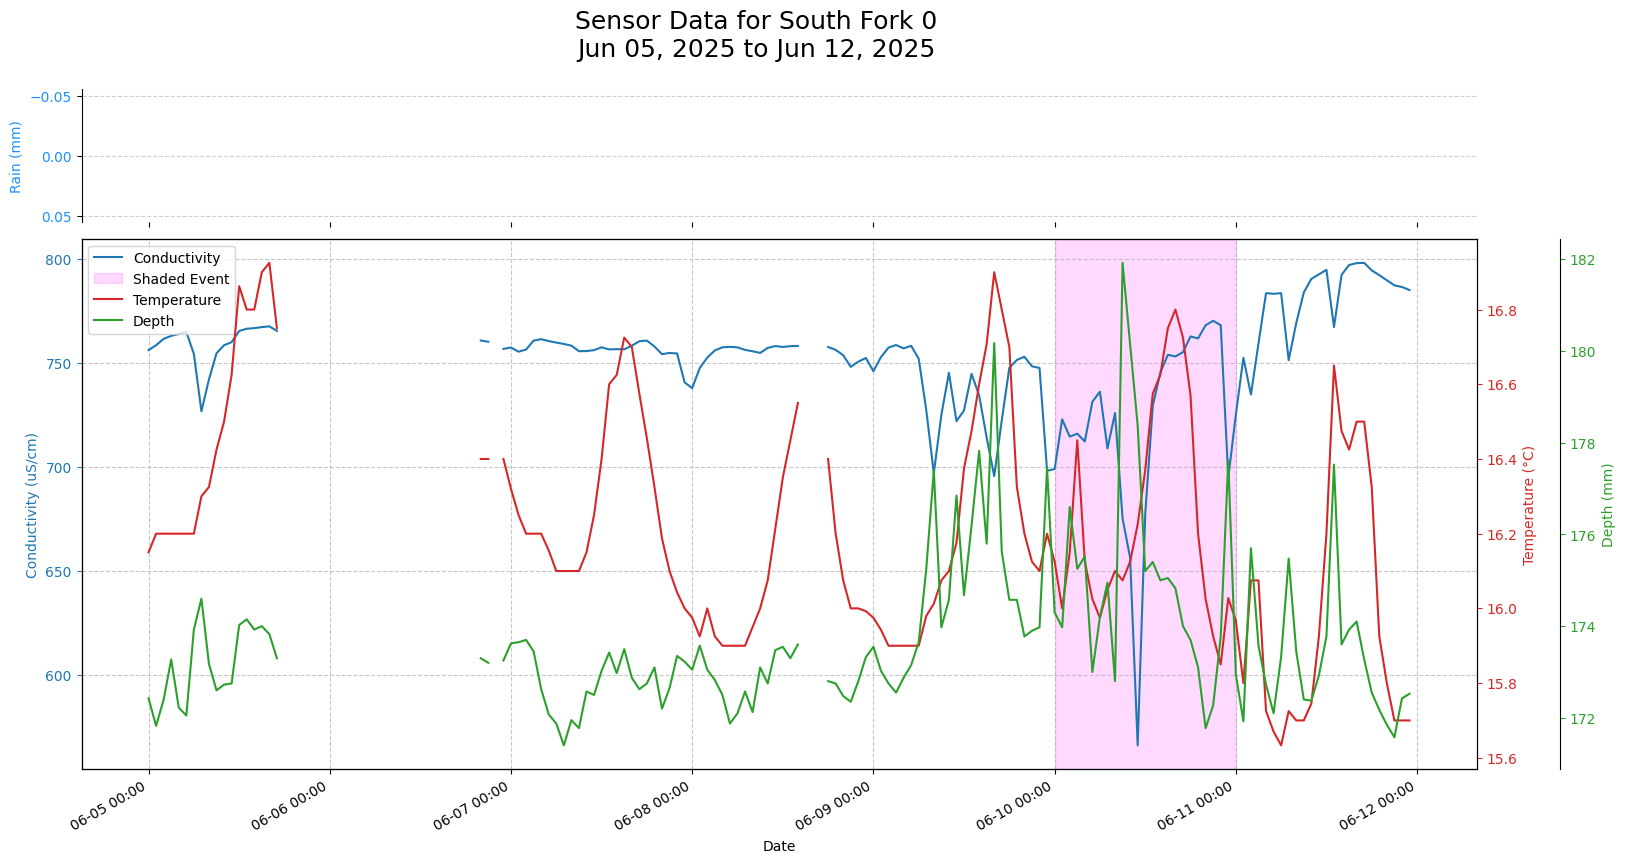

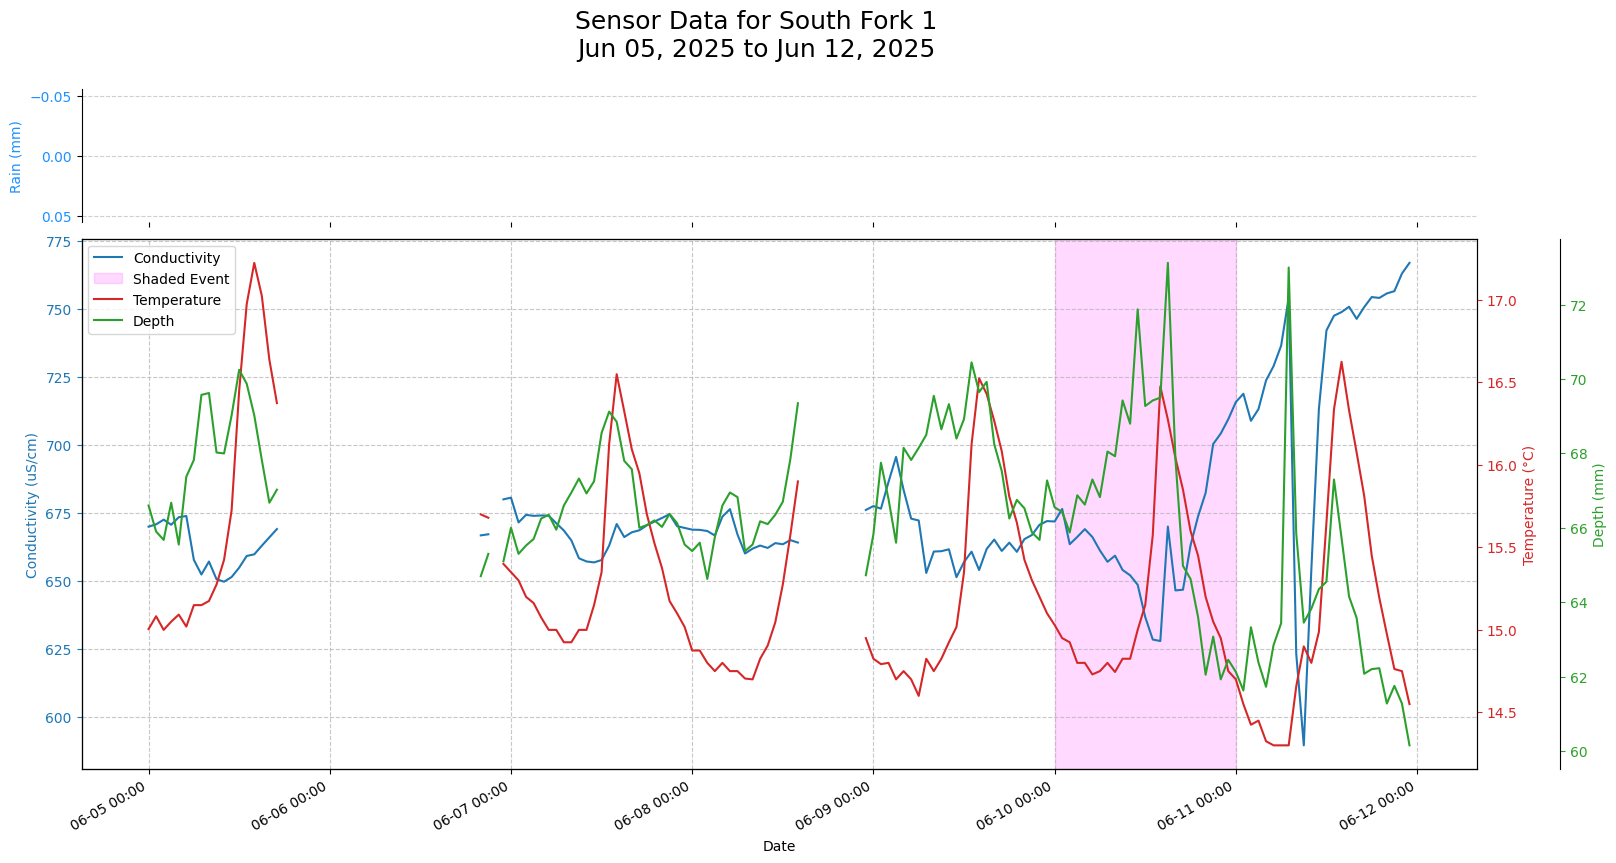

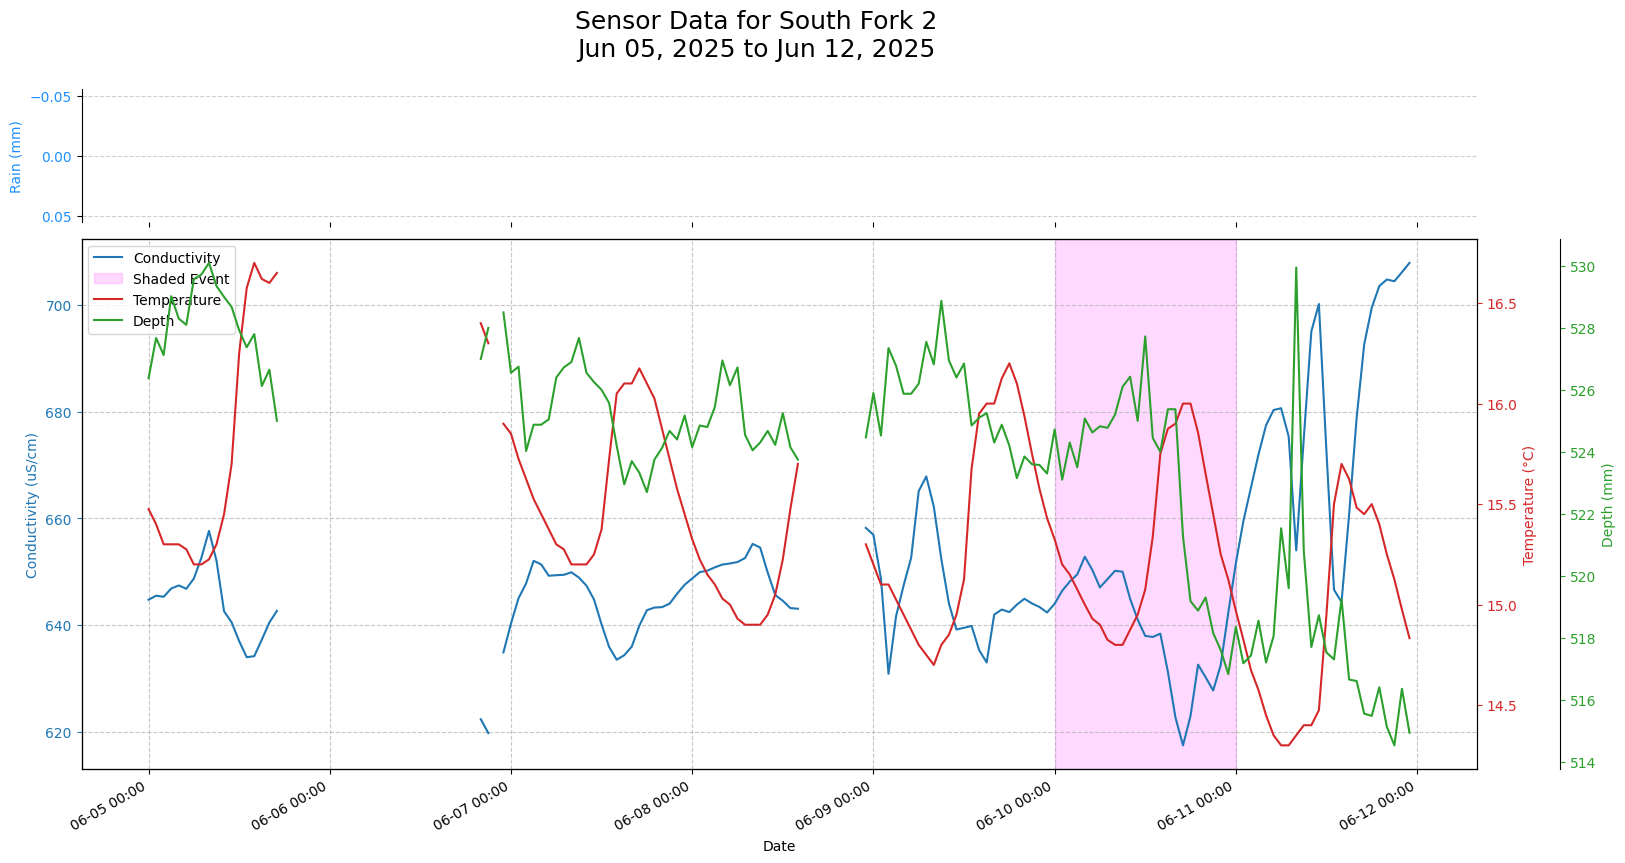

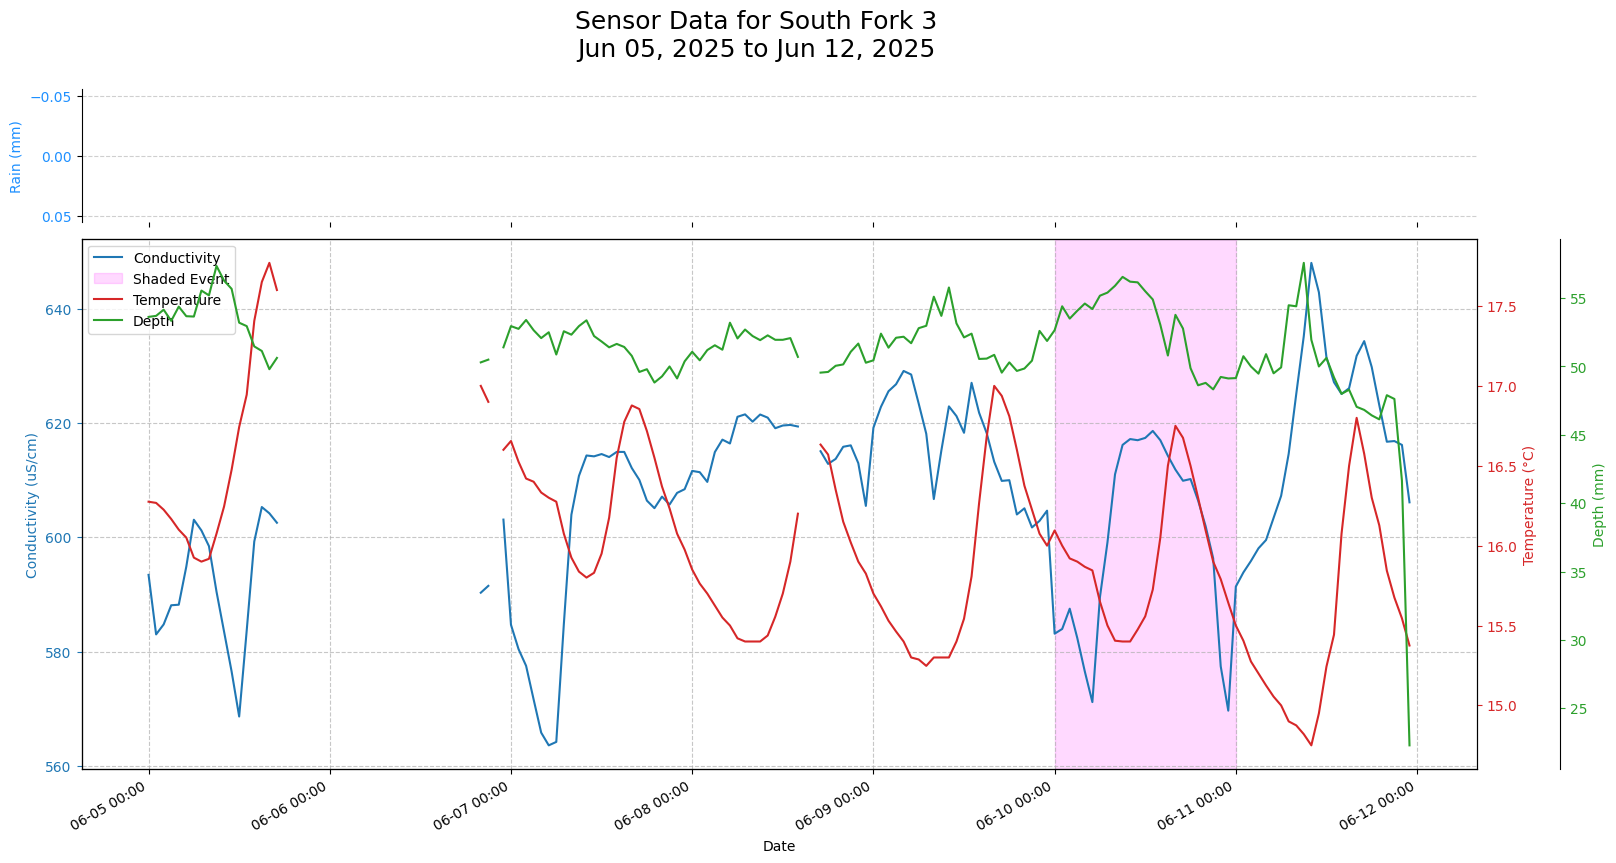


--- Plotting complete ---


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===================================================================
#  1. NEW PLOTTING FUNCTION
# ===================================================================

def plot_south_fork_data(df, location_info, start_date_str, end_date_str, shade_start_str=None, shade_end_str=None, hours_avg=None):
    """
    Plots sensor data for a specific location and date range with a dedicated
    rain subplot at the top and an optional shaded region.
    
    Args:
        df (pd.DataFrame): The final, merged DataFrame.
        location_info (dict): A dictionary containing the 'table' and 'label' for the site.
        start_date_str (str): The start date for the plot (e.g., '2025-06-05').
        end_date_str (str): The end date for the plot (e.g., '2025-06-10').
        shade_start_str (str, optional): The start date for the shaded region.
        shade_end_str (str, optional): The end date for the shaded region.
        hours_avg (int, optional): The number of hours to resample/average the data by.
    """
    location_id = location_info['table']
    site_label = location_info['label']
    
    # Convert string dates to timezone-aware pandas Timestamps
    start_date = pd.to_datetime(start_date_str).tz_localize('America/Los_Angeles')
    end_date = pd.to_datetime(end_date_str).tz_localize('America/Los_Angeles')
    
    # Filter the DataFrame for the specific location and date range
    plot_df = df[(df['location'] == location_id) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    
    if plot_df.empty:
        print(f"⚠️ No data found for '{site_label}' in the range {start_date.date()} to {end_date.date()}.")
        return
        
    plot_df = plot_df.set_index('datetime').sort_index()
    
    # Optional: Resample data to an hourly average
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
        
    # --- Plotting Setup ---
    fig, (ax_rain, ax_main) = plt.subplots(
        2, 1, 
        figsize=(18, 10), 
        sharex=True, 
        gridspec_kw={'height_ratios': [1, 4], 'hspace': 0.05}
    )
    
    title = f"Sensor Data for {site_label}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=18, y=0.96)

    # --- Top Plot: Rain ---
    if 'rain_mm' in plot_df.columns:
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.04, color='dodgerblue', alpha=0.7)
        ax_rain.set_ylabel('Rain (mm)', color='dodgerblue')
        ax_rain.tick_params(axis='y', labelcolor='dodgerblue')
        ax_rain.spines['top'].set_visible(False)
        ax_rain.spines['right'].set_visible(False)
        ax_rain.spines['bottom'].set_visible(False)
        ax_rain.invert_yaxis()
        ax_rain.grid(True, linestyle='--', alpha=0.6, axis='y')

    # --- Bottom Plot: Sensor Data ---
    ax_main.set_xlabel("Date")
    ax_main.grid(True, linestyle='--', alpha=0.7)
    
    # Create the axes for each sensor type
    ax_cond = ax_main
    ax_temp = ax_main.twinx()
    ax_depth = ax_main.twinx()
    
    ax_depth.spines['right'].set_position(('outward', 60))

    # Plot the data
    p1, = ax_cond.plot(plot_df.index, plot_df['conductivity'], color='tab:blue', label='Conductivity')
    p2, = ax_temp.plot(plot_df.index, plot_df['temperature'], color='tab:red', label='Temperature')
    p3, = ax_depth.plot(plot_df.index, plot_df['depth'], color='tab:green', label='Depth')
    
    # Set labels and colors
    ax_cond.set_ylabel('Conductivity (uS/cm)', color=p1.get_color())
    ax_temp.set_ylabel('Temperature (°C)', color=p2.get_color())
    ax_depth.set_ylabel('Depth (mm)', color=p3.get_color())
    
    ax_cond.tick_params(axis='y', colors=p1.get_color())
    ax_temp.tick_params(axis='y', colors=p2.get_color())
    ax_depth.tick_params(axis='y', colors=p3.get_color())

    # --- Shaded Region ---
    if shade_start_str and shade_end_str:
        shade_start = pd.to_datetime(shade_start_str).tz_localize('America/Los_Angeles')
        shade_end = pd.to_datetime(shade_end_str).tz_localize('America/Los_Angeles')
        ax_main.axvspan(shade_start, shade_end, color='magenta', alpha=0.15, label='Shaded Event')

    # Set the x-axis to display dates nicely
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=plot_df.index.tz))
    fig.autofmt_xdate()
    
    # Create a single legend for all lines and the shaded region
    handles, labels = ax_main.get_legend_handles_labels()
    # Add handles from the other axes if they exist
    if 'p2' in locals(): handles.append(p2)
    if 'p3' in locals(): handles.append(p3)
    ax_main.legend(handles=handles, loc='upper left')
    
    plt.show()

# ===================================================================
#  2. MAIN WORKFLOW FOR PLOTTING
# ===================================================================

# This cell assumes 'final_df' has been created and is available in the environment.

# Define the sites and date range for plotting
SITES_TO_PLOT = [
    {"table": "south_fork_0", "label": "South Fork 0"},
    {"table": "south_fork_1", "label": "South Fork 1"},
    {"table": "south_fork_2", "label": "South Fork 2"},
    {"table": "south_fork_3", "label": "South Fork 3"},
]
START_DATE = '2025-06-05'
END_DATE = '2025-06-12'

# Define the day to shade. To shade a full day, set the end to the *next* day.
SHADE_START = '2025-06-10'
SHADE_END = '2025-06-11'

print(f"\n--- Generating plots for South Fork sensors from {START_DATE} to {END_DATE} ---")
print(f"--- Shading event from {SHADE_START} to {SHADE_END} ---")

# Loop through the specified sites and generate a plot for each one
for site in SITES_TO_PLOT:
    plot_south_fork_data(
        df=final_df,
        location_info=site,
        start_date_str=START_DATE,
        end_date_str=END_DATE,
        shade_start_str=SHADE_START,
        shade_end_str=SHADE_END,
        hours_avg=1 # Average data to 1-hour intervals for a cleaner plot
    )

print("\n--- Plotting complete ---")